In [2323]:
config = {
    "sender_size": 30,
    "receiver_size": 20,
    "transmitting": 5,
    "transmission_prob": 1,
    "chaos_level": 1
}

report_root = "report"
notebook_filename = "brain.ipynb"

add_semantic_edges=False
logical_similarity=0.5

In [2324]:
def transform_weights_to_gaussian_profile(graph, center=0.7, sharpness=10.0):
    """
    Applies a Gaussian-like function to similarity scores to emphasize central weights.
    """
    for u, v, data in graph.edges(data=True):
        sim = data.get("predictive_similarity", 0.0)
        transformed = np.exp(-sharpness * (sim - center)**2)
        data["weight"] = transformed

In [2325]:
import os


def get_report_subdir(report_root="report"):
    subdir = os.path.join(
        report_root,
        f"{config['sender_size']}_{config['receiver_size']}_{config['transmitting']}_{config['transmission_prob']}_{config['chaos_level']}"
    )
    os.makedirs(subdir, exist_ok=True)
    return subdir

In [2326]:
import os
import csv


def save_csv_to_report_dir(data_rows, header, filename, report_root="report"):
    """
    Zapisuje dane do pliku CSV w folderze wynikowym wg ścieżki zależnej od konfiguracji.

    Parameters:
        data_rows (list of tuples/lists): dane do zapisania (wiersze)
        header (list of str): nagłówki kolumn
        filename (str): nazwa pliku, np. "transmission_sequence.csv"
        report_root (str): katalog główny na wyniki (domyślnie: "report")
    """
    save_dir = os.path.join(
        get_report_subdir(report_root)
    )
    os.makedirs(save_dir, exist_ok=True)
    file_path = os.path.join(save_dir, filename)

    with open(file_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        if header:
            writer.writerow(header)
        writer.writerows(data_rows)

    print(f" Zapisano plik CSV do: {file_path}")
    return file_path

In [2327]:
from scipy.spatial.distance import cosine


def reclassify_implanted_edges(receiver_G, transmitted_graph, mapping, similarity_threshold=0.85):
    """
    Reclassify edges between IMPLANTED nodes in the receiver graph as 'semantic' 
    if they were not present in the original transmitted graph, but the embeddings 
    indicate high semantic similarity.

    Parameters:
        receiver_G (nx.Graph): The receiver's cognitive graph after implantation.
        transmitted_graph (nx.Graph): The graph that was originally transmitted.
        mapping (dict): A dictionary mapping original node IDs to receiver node IDs.
        similarity_threshold (float): Cosine similarity threshold for semantic labeling.
    """
    reverse_mapping = {v: k for k, v in mapping.items()}

    for u, v, data in receiver_G.edges(data=True):
        if u == v:
            continue

        if receiver_G.nodes[u].get("state") == "IMPLANTED" and receiver_G.nodes[v].get("state") == "IMPLANTED":
            orig_u = reverse_mapping.get(u)
            orig_v = reverse_mapping.get(v)

            if orig_u is None or orig_v is None:
                continue
            if transmitted_graph.has_edge(orig_u, orig_v):
                continue

            emb_u = receiver_G.nodes[u].get("embedding")
            emb_v = receiver_G.nodes[v].get("embedding")

            if emb_u is not None and emb_v is not None:
                similarity = 1 - cosine(emb_u, emb_v)
                if similarity > similarity_threshold:
                    data['type'] = "semantic"
                    data['weight'] = max(data.get('weight', 0), similarity)

In [2328]:
def compute_node_information_receiver(node, receiver_graph, cluster_sequence, known_clusters, last_cluster):
    import math

    cluster = receiver_graph.nodes[node].get("cluster", -1)

    # Shannon entropy / rarity
    if cluster_sequence:
        p_cluster = cluster_sequence.count(cluster) / len(cluster_sequence)
        shannon_info = - \
            math.log2(p_cluster) if p_cluster > 0 else math.log2(
                len(set(cluster_sequence)) + 1)
    else:
        shannon_info = math.log2(2)  # default for first node

    # Semantic surprise (transition between clusters)
    if last_cluster is not None:
        semantic_surprise = 1.0 if cluster != last_cluster else 0.0
    else:
        semantic_surprise = 1.0

    # Topological importance
    degree_centrality = receiver_graph.degree[node] if receiver_graph.degree[node] > 0 else 1

    # Final score: weighted sum
    total_info = shannon_info + semantic_surprise + \
        math.log2(degree_centrality + 1)
    return total_info

In [2329]:
import os
import csv


def export_edge_weights(graph, name, report_root="report"):
    """
    Export all edge weights from the given graph into a structured CSV file.

    Parameters:
        graph (networkx.Graph): The graph containing edges with weights.
        name (str): Descriptive name of the snapshot, e.g., 'receiver_before' or 'receiver_after'.
        report_root (str): Root directory for storing analysis reports.

    Returns:
        str: Path to the saved CSV file.
    """
    # Construct a unique directory based on simulation parameters
    save_dir = os.path.join(
        get_report_subdir(report_root),
        "weights"
    )
    os.makedirs(save_dir, exist_ok=True)

    file_path = os.path.join(save_dir, f"{name}_edge_weights.csv")

    # Prepare edge data
    edge_rows = [
        (u, v, round(data.get("weight", 0.0), 4))
        for u, v, data in graph.edges(data=True)
    ]

    # Write to CSV
    with open(file_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Node1", "Node2", "Weight"])
        writer.writerows(edge_rows)

    print(f" Saved edge weights to: {file_path}")
    return file_path

In [2330]:
import matplotlib.pyplot as plt
import os
from collections import Counter


def plot_cluster_distribution(graph, title="Cluster Distribution", report_root="report", filename="cluster_distribution.png"):
    """
    Plots and saves the distribution of nodes across clusters.

    Parameters:
        graph (networkx.Graph): The graph with nodes having 'cluster' attribute.
        title (str): Title of the plot.
        report_root (str): Directory to save the report.
        filename (str): Output file name.
    """
    cluster_ids = [d.get("cluster", -1) for _, d in graph.nodes(data=True)]
    counter = Counter(cluster_ids)

    clusters = sorted(counter.keys())
    counts = [counter[c] for c in clusters]

    plt.figure(figsize=(10, 5))
    plt.bar([str(c) for c in clusters], counts,
            color='cornflowerblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Nodes")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    save_dir = os.path.join(get_report_subdir(
        report_root), "cluster_distribution")
    os.makedirs(save_dir, exist_ok=True)
    output_path = os.path.join(save_dir, filename)
    plt.savefig(output_path)
    plt.close()
    print(f"Cluster distribution plot saved to: {output_path}")

In [2331]:
# from scipy.spatial.distance import cosine
# import numpy as np


# def assign_predictive_weights(graph, default_weight=0.1):
#     """
#     Assigns predictive weights to edges based on cosine similarity between node embeddings.
#     Higher similarity implies stronger predictive certainty and lower free energy.

#     Parameters:
#         graph (networkx.Graph): A graph with 'embedding' attribute for nodes.
#         default_weight (float): Fallback weight if embeddings are missing or invalid.
#     """
#     for u, v, data in graph.edges(data=True):
#         emb_u = graph.nodes[u].get("embedding")
#         emb_v = graph.nodes[v].get("embedding")

#         if emb_u is not None and emb_v is not None:
#             similarity = 1 - cosine(emb_u, emb_v)
#             # Handle numerical instability
#             if np.isnan(similarity) or similarity < 0:
#                 similarity = 0.0
#         else:
#             similarity = default_weight

#         # Store both weight and similarity for analysis
#         data["predictive_similarity"] = similarity
#         data["weight"] = similarity

In [2332]:
def assign_predictive_weights_gaussian(graph, mu=0.5, sigma=0.15):
    """
    Przypisuje wagi z rozkładu normalnego – imitując naturalną zmienność.
    """
    for u, v, data in graph.edges(data=True):
        weight = np.clip(np.random.normal(mu, sigma), 0, 1)
        data["weight"] = weight
        data["predictive_similarity"] = weight

In [2333]:
import numpy as np
import networkx as nx


def assign_cluster_embeddings(graph, dim=8, seed=42, alpha=0.6, noise_std=0.3):
    """
    Assigns semantic embeddings to each node based on its cluster membership.
    Nodes in the same cluster receive similar (but not identical) embeddings.

    Parameters:
        graph (networkx.Graph): Graph where each node has a 'cluster' attribute.
        dim (int): Dimensionality of the embedding vectors.
        seed (int): Random seed for reproducibility.
        alpha (float): Blend factor between cluster center and noise (0.0 = full noise, 1.0 = no noise).
        noise_std (float): Standard deviation of Gaussian noise added to diversify embeddings.
    """
    np.random.seed(seed)

    # Extract cluster assignments
    cluster_attr = nx.get_node_attributes(graph, 'cluster')
    unique_clusters = set(cluster_attr.values())

    # Generate a base vector for each cluster
    cluster_embeddings = {
        cluster_id: np.random.rand(dim)
        for cluster_id in unique_clusters
    }

    for node in graph.nodes:
        cluster_id = cluster_attr.get(node)
        if cluster_id is not None:
            base_vector = cluster_embeddings[cluster_id]
            noise = np.random.normal(loc=0.0, scale=noise_std, size=dim)
            # Blend base with noise for individual variance
            embedding = alpha * base_vector + (1 - alpha) * noise
        else:
            # Unclustered node → assign random vector
            embedding = np.random.rand(dim)

        graph.nodes[node]['embedding'] = embedding

In [2334]:
import networkx as nx
import community as community_louvain  # python-louvain package


def detect_brain_clusters(G):
    """
    Detects semantic or functional clusters in a cognitive graph using Louvain modularity optimization.

    Parameters:
        G (networkx.Graph): The input graph representing the brain/memory structure.

    Returns:
        dict: A mapping {node_id: cluster_id}, also saved to node attributes as 'cluster'.
    """
    # Perform community detection ignoring edge weights
    partition = community_louvain.best_partition(
        G, weight='none')  # 'none' as string is required

    # Attach cluster labels to nodes
    nx.set_node_attributes(G, partition, "cluster")

    return partition

In [2335]:
import networkx as nx


def build_brain(num_nodes):
    """
    Constructs a connected small-world brain graph with labeled and inactive nodes.

    Parameters:
        num_nodes (int): Number of nodes to include in the graph.

    Returns:
        networkx.Graph: A connected graph modeling a simplified brain structure.
    """
    # Generate a connected small-world graph
    G = nx.connected_watts_strogatz_graph(n=num_nodes, k=4, p=0.3, tries=100)

    # Initialize node attributes
    for i in G.nodes:
        G.nodes[i]['label'] = str(i)  # Unique identifier
        # Can later be set to ACTIVE or IMPLANTED
        G.nodes[i]['state'] = 'INACTIVE'

    return G

In [2336]:
import networkx as nx
import random
from collections import deque


def generate_information_subgraph(brain_graph, num_info_nodes, chaos_level=0.0):
	"""
	Generates a subgraph representing a message to be transmitted, with a controllable level of semantic structure vs. chaos.

	Parameters:
		brain_graph (networkx.Graph): The sender's cognitive graph.
		num_info_nodes (int): Number of nodes to include in the message.
		chaos_level (float): Degree of disorder in selection [0.0 = structured, 1.0 = random].

	Returns:
		networkx.Graph: A subgraph with selected 'INFORMATION' nodes, preserving labels and optional semantic links.
	"""
	all_nodes = list(brain_graph.nodes)
	info_nodes = []
	visited = set()

	if chaos_level == 0.0:
		# STRUCTURED: Select using BFS (semantic wave)
		start_node = random.choice(all_nodes)
		queue = deque([start_node])
		while queue and len(info_nodes) < num_info_nodes:
			current = queue.popleft()
			if current not in visited:
				visited.add(current)
				info_nodes.append(current)
				queue.extend(n for n in brain_graph.neighbors(
					current) if n not in visited)
	else:
		# CHAOTIC: Random nodes
		info_nodes = random.sample(all_nodes, num_info_nodes)

	# Build the information graph
	info_graph = nx.Graph()
	for idx, node in enumerate(info_nodes):
		info_graph.add_node(node)
		info_graph.nodes[node]['label'] = brain_graph.nodes[node].get(
			'label', str(node))
		info_graph.nodes[node]['state'] = 'INFORMATION'
		info_graph.nodes[node]['sequence'] = idx

	# Add existing edges from brain
	for u in info_nodes:
		for v in brain_graph.neighbors(u):
			if v in info_nodes:
				info_graph.add_edge(u, v)


	# Add semantic chain only if enabled explicitly
	if chaos_level == 1.0:
		for i in range(len(info_nodes) - 1):
			u, v = info_nodes[i], info_nodes[i + 1]
			if not info_graph.has_edge(u, v):
				info_graph.add_edge(u, v, type='semantic')


	return info_graph

In [ ]:
import math
from scipy.spatial.distance import cosine


def compute_node_information(node, graph, cluster_sequence, known_clusters, last_cluster, embedding_history=None):
    """
    Computes the informational contribution of a node using:
    - Entropy-like novelty from embedding distance
    - Semantic sequence surprise
    - Degree-based structural relevance

    Parameters:
        node (int): ID of the current node.
        graph (nx.Graph): Cognitive graph (sender or receiver).
        cluster_sequence (list[int]): Encountered clusters so far.
        known_clusters (set[int]): Visited cluster IDs.
        last_cluster (int or None): Previous cluster ID.
        embedding_history (list[np.array]): Embeddings of prior nodes (optional).

    Returns:
        float: Total information score for the node.
    """
    cluster = graph.nodes[node].get("cluster", -1)
    state = graph.nodes[node].get("state", "UNKNOWN")
    degree = graph.degree[node]
    emb = graph.nodes[node].get("embedding", None)

    # === ENTROPY BASED ON EMBEDDING NOVELTY ===
    if emb is None or not embedding_history:
        shannon_info = 1.0  # fallback default
    else:
        # Compute average cosine distance to past embeddings
        distances = [cosine(emb, past)
                     for past in embedding_history if past is not None]
        avg_distance = sum(distances) / len(distances) if distances else 0.0
        # Transform distance to pseudo-entropy
        # to avoid log(0)
        shannon_info = max(0.0, -math.log2(1.0 - avg_distance + 1e-6))

    # === SEQUENCE SURPRISE ===
    if last_cluster is None:
        sequence_surprise = 2.0
    elif cluster == last_cluster:
        sequence_surprise = 0.3
    elif cluster in known_clusters:
        sequence_surprise = 1.0
    else:
        sequence_surprise = 2.0

    # === STRUCTURAL SIGNAL ===
    degree_info = math.log2(degree + 1)

    # === Penalize known (RECEIVED) nodes ===
    if state == "RECEIVED":
        shannon_info *= 0.4
        sequence_surprise *= 0.4
        degree_info *= 0.5

    # === TOTAL SCORE ===
    total_info = shannon_info + sequence_surprise + 0.5 * degree_info
    return total_info

In [2345]:
from collections import Counter
import numpy as np
import random
from scipy.spatial.distance import cosine


def transmit_information_with_contextual_returns(
    info_graph,
    transmission_prob,
    start=None,
    cluster_attr="cluster"
):
    transmitted_nodes = []
    transmission_sequence = []
    decision_log = []
    info_scores = {}
    cluster_sequence = []
    known_clusters = set()
    last_cluster = None
    visited = set()

    all_nodes = list(info_graph.nodes)

    # Select a random starting node if none is provided
    if start is None:
        start = random.choice(all_nodes)

    stack = [start]
    backtrack_stack = []

    all_clusters = [info_graph.nodes[n].get(
        cluster_attr, -1) for n in all_nodes]
    n_clusters = len(set(all_clusters))
    min_p = 1 / max(n_clusters, 1)

    while stack or backtrack_stack:
        # Return to previously visited nodes with unexplored neighbors
        if not stack and backtrack_stack:
            while backtrack_stack:
                candidate = backtrack_stack.pop()
                neighbors = list(info_graph.neighbors(candidate))
                unvisited_neighbors = [
                    n for n in neighbors if n not in visited and n != candidate]
                if unvisited_neighbors:
                    stack.append(candidate)
                    break

        if not stack:
            break

        node = stack.pop()
        if node in visited:
            continue

        # Apply probabilistic dropout to simulate imperfect transmission
        if random.random() > transmission_prob:
            decision_log.append({
                "current_node": node,
                "candidate": None,
                "edge_weight": None,
                "edge_type": None,
                "priority": None,
                "selected": False,
                "skipped": True
            })
            continue

        # Compute information score based on novelty and structural properties
        cluster = info_graph.nodes[node].get(cluster_attr, -1)
        total_info = compute_node_information(
            node=node,
            graph=info_graph,
            cluster_sequence=cluster_sequence,
            known_clusters=known_clusters,
            last_cluster=last_cluster
        )

        visited.add(node)
        transmitted_nodes.append(node)
        transmission_sequence.append(node)
        info_scores[node] = total_info
        cluster_sequence.append(cluster)
        known_clusters.add(cluster)
        last_cluster = cluster

        # Rank neighbors by descending edge weight
        neighbors = sorted(
            info_graph.neighbors(node),
            key=lambda n: info_graph.edges[node, n].get("weight", 0),
            reverse=True
        )
        unvisited_neighbors = [
            n for n in neighbors if n not in visited and n != node]

        # Select neighbors based on transmission probability
        selected_neighbors = [
            n for n in unvisited_neighbors if random.random() <= transmission_prob
        ]

        # Store context for possible future returns
        if selected_neighbors:
            backtrack_stack.append(node)
            stack.extend(reversed(selected_neighbors))

        for neighbor in unvisited_neighbors:
            emb_u = info_graph.nodes[node].get("embedding")
            emb_v = info_graph.nodes[neighbor].get("embedding")

            if emb_u is not None and emb_v is not None:
                similarity = 1 - cosine(emb_u, emb_v)
                edge_type = "logical" if similarity >= 0.6 else "semantic"
                info_graph.edges[node, neighbor]["type"] = edge_type
                info_graph.edges[node, neighbor]["weight"] = similarity
            else:
                similarity = 0.0
                edge_type = "semantic"
                info_graph.edges[node, neighbor]["type"] = edge_type
                info_graph.edges[node, neighbor]["weight"] = similarity

            decision_log.append({
                "current_node": node,
                "candidate": neighbor,
                "edge_weight": round(similarity, 4),
                "edge_type": edge_type,
                "priority": unvisited_neighbors.index(neighbor) + 1,
                "selected": neighbor in selected_neighbors,
                "skipped": False
            })

    # Add missing edges between consecutive transmitted nodes
    for i in range(len(transmission_sequence) - 1):
        u = transmission_sequence[i]
        v = transmission_sequence[i + 1]
        if u != v and not info_graph.has_edge(u, v):
            emb_u = info_graph.nodes[u].get("embedding")
            emb_v = info_graph.nodes[v].get("embedding")
            if emb_u is not None and emb_v is not None:
                similarity = 1 - cosine(emb_u, emb_v)
                edge_type = "logical" if similarity >= 0.6 else "semantic"
                info_graph.add_edge(u, v, type=edge_type, weight=similarity)
                print(
                    f"Added {edge_type} edge: {u}–{v} (similarity={similarity:.4f})")
            else:
                info_graph.add_edge(u, v, type="semantic", weight=0.0)
                print(
                    f"Added fallback semantic edge (missing embeddings): {u}–{v}")

    # Construct the final subgraph of transmitted nodes
    transmitted_graph = info_graph.subgraph(set(transmitted_nodes)).copy()
    for n in transmitted_graph.nodes:
        transmitted_graph.nodes[n]["state"] = "TRANSMITTED"

    avg_info = np.mean(list(info_scores.values())) if info_scores else 0.0

    return transmitted_graph, info_scores, avg_info, transmission_sequence, decision_log

In [2346]:
import networkx as nx


def integrate_into_receiver(receiver_G, transmitted_graph, transmission_sequence=None, add_semantic_edges=True, preserve_semantic_edges=True):
	"""
	Integrates the transmitted graph into the receiver's brain structure.
	Maps known concepts, implants unknown ones, and preserves semantic continuity.

	Parameters:
		receiver_G (networkx.Graph): The receiver's cognitive graph.
		transmitted_graph (networkx.Graph): The subgraph that was transmitted.
		transmission_sequence (list or None): Optional ordered list of original nodes.

	Returns:
		dict: Mapping from transmitted node IDs to node IDs in the receiver graph.
	"""
	mapping = {}
	receiver_labels = nx.get_node_attributes(receiver_G, 'label')
	used_nodes = set()

	# Step 1: Map nodes based on label endings
	# for node in transmitted_graph.nodes:
	# 	info_label = transmitted_graph.nodes[node]['label']
	# 	match = None

	# 	for rcv_node, rcv_label in receiver_labels.items():
	# 		if rcv_label.endswith(info_label.split('_')[-1]) and rcv_node not in used_nodes:
	# 			match = rcv_node
	# 			break

	# 	if match is not None:
	# 		mapping[node] = match
	# 		receiver_G.nodes[match]['state'] = 'RECEIVED'
	# 		used_nodes.add(match)
	# 	else:
	# 		# Implant new node if no match
	# 		new_node_id = max(receiver_G.nodes) + 1
	# 		receiver_G.add_node(
	# 			new_node_id,
	# 			label=f"implanted_{info_label}",
	# 			state='IMPLANTED'
	# 		)
	# 		mapping[node] = new_node_id
	# 		used_nodes.add(new_node_id)

	for node in transmitted_graph.nodes:
		info_label = transmitted_graph.nodes[node]['label']
		match = None

		for rcv_node, rcv_label in receiver_labels.items():
			if rcv_label.endswith(info_label.split('_')[-1]) and rcv_node not in used_nodes:
				match = rcv_node
				break

		if match is not None:
			mapping[node] = match
			receiver_G.nodes[match]['state'] = 'RECEIVED'
			receiver_G.nodes[match]['origin_id'] = node  # 🔗 dodaj powiązanie z senderem
			used_nodes.add(match)
		else:
			new_node_id = max(receiver_G.nodes) + 1
			receiver_G.add_node(
				new_node_id,
				label=f"implanted_{info_label}",
				state='IMPLANTED',
				origin_id=node  # 🔗 dodaj powiązanie z senderem
			)
			mapping[node] = new_node_id
			used_nodes.add(new_node_id)


	# Step 2: Add original transmitted edges to receiver graph
	for u, v in transmitted_graph.edges:
		u_map, v_map = mapping[u], mapping[v]
		if not receiver_G.has_edge(u_map, v_map):
			edge_type = transmitted_graph.edges[u, v].get('type', 'structural')
			if edge_type == 'semantic' and not preserve_semantic_edges:
				continue  # pomiń semantyczne relacje jeśli nie chcemy ich przenosić

			edge_weight = transmitted_graph.edges[u, v].get('weight', 1.0)
			receiver_G.add_edge(
				u_map, v_map, weight=edge_weight, type=edge_type)

	# # Step 3: Add semantic continuity based on transmission sequence
	# if transmission_sequence:
	# 	for i in range(len(transmission_sequence) - 1):
	# 		a_orig, b_orig = transmission_sequence[i], transmission_sequence[i + 1]
	# 		a, b = mapping[a_orig], mapping[b_orig]
	# 		if not receiver_G.has_edge(a, b):
	# 			receiver_G.add_edge(a, b, weight=0.5, type="semantic")

	# Step 3: Add semantic continuity based on transmission sequence
	if transmission_sequence and preserve_semantic_edges:
		for i in range(len(transmission_sequence) - 1):
			a_orig, b_orig = transmission_sequence[i], transmission_sequence[i + 1]
			a, b = mapping[a_orig], mapping[b_orig]
			if not receiver_G.has_edge(a, b):
				receiver_G.add_edge(a, b, weight=0.5, type="semantic")


	return mapping

In [2347]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx


def visualize_overlay_brain_with_highlight(
	receiver_brain_before,
	receiver_brain_after,
	pos=None,
	show=False,
	report_root="report"
):
	"""
	Visualizes the receiver brain after information integration.
	Highlights node states (RECEIVED, IMPLANTED, INACTIVE) and edge types (semantic, structural, logical).

	Parameters:
		receiver_brain_before (networkx.Graph): Graph before integration (not used directly here).
		receiver_brain_after (networkx.Graph): Graph after integration.
		pos (dict): Optional fixed layout positions for consistency across runs.
		show (bool): Whether to display the plot interactively.
		report_root (str): Root directory for saving output.

	Returns:
		str: Path to the saved PNG file.
	"""
	save_dir = os.path.join(
		get_report_subdir(report_root),
		"brain_state"
	)
	os.makedirs(save_dir, exist_ok=True)
	output_path = os.path.join(save_dir, "overlay_brain.png")

	if pos is None:
		pos = nx.spring_layout(receiver_brain_after, seed=42)

	# Node colors and sizes based on cognitive state
	color_map = []
	node_sizes = []
	for node in receiver_brain_after.nodes:
		state = receiver_brain_after.nodes[node].get('state', 'UNKNOWN')
		if state == 'RECEIVED':
			color_map.append('gold')
			node_sizes.append(500)
		elif state == 'IMPLANTED':
			color_map.append('red')
			node_sizes.append(600)
		elif state == 'INACTIVE':
			color_map.append('lightblue')
			node_sizes.append(300)
		else:
			color_map.append('lightgray')
			node_sizes.append(250)


	# Edge colors based on type
	edge_colors = []
	for _, _, data in receiver_brain_after.edges(data=True):
		edge_type = data.get('type', 'other')
		if edge_type == 'semantic':
			edge_colors.append('red')
		elif edge_type == 'structural':
			edge_colors.append('black')
		elif edge_type == 'logical':
			edge_colors.append('blue')
		else:
			edge_colors.append('gray')

	# Plotting
	plt.figure(figsize=(12, 10))
	nx.draw(
		receiver_brain_after, pos,
		node_color=color_map,
		edge_color=edge_colors,
		with_labels=True,
		font_size=12,
		node_size=node_sizes
	)

	# Legend
	legend_elements = [
		mpatches.Patch(color='red', label='New nodes (IMPLANTED)'),
		mpatches.Patch(color='gold', label='Matched nodes (RECEIVED)'),
		mpatches.Patch(color='lightblue', label='Existing inactive'),
		mpatches.Patch(color='lightgray', label='Unlabeled/unknown'),
		mpatches.Patch(color='black', label='Structural connections'),
		mpatches.Patch(color='red', label='Semantic connections'),
		mpatches.Patch(color='blue', label='Logical connections')
	]
	plt.legend(handles=legend_elements, loc='lower left', fontsize=8)
	plt.title("Overlay of Receiver Brain After Semantic Integration")
	plt.axis('off')
	plt.tight_layout()
	plt.savefig(output_path)

	if show:
		plt.show()
	else:
		plt.close()

	print(f"Saved overlay to: {output_path}")
	return output_path

In [ ]:
import os
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches


def visualize_brain_states(
	sender_brain,
	info_graph,
	transmitted_graph,
	receiver_brain_before,
	receiver_brain_after,
	pos=None
):
	"""
	Visualizes the full trajectory of cognitive transmission:
	- Sender brain with highlighted information nodes,
	- Transmitted subgraph (Shannon model),
	- Receiver brain before transmission,
	- Receiver brain after semantic integration.

	Parameters:
		sender_brain (networkx.Graph): Full network of the sender.
		info_graph (networkx.Graph): Subgraph representing selected information.
		transmitted_graph (networkx.Graph): Graph that was transmitted.
		receiver_brain_before (networkx.Graph): Receiver graph before integration.
		receiver_brain_after (networkx.Graph): Receiver graph after integration.
		pos (dict or None): Optional fixed layout for consistent positioning.

	Returns:
		None (saves figures to disk in appropriate report folder).
	"""
	save_dir = os.path.join(
		get_report_subdir(report_root),
		"brain_state"
	)
	os.makedirs(save_dir, exist_ok=True)

	# --- 1. Sender brain with info highlighted ---
	sender_pos = nx.spring_layout(sender_brain, seed=42)
	sender_colors = [
		'gold' if node in info_graph.nodes else 'lightgray' for node in sender_brain.nodes]
	sender_labels = {
		node: sender_brain.nodes[node]['label'] for node in sender_brain.nodes if node in info_graph.nodes
	}

	plt.figure(figsize=(10, 8))
	nx.draw(
		sender_brain, sender_pos,
		node_color=sender_colors,
		labels=sender_labels,
		font_size=12,
		with_labels=True,
		node_size=300,
		edge_color='gray'
	)
	plt.title("1. Sender brain – highlighted information nodes")
	plt.axis('off')
	plt.tight_layout()
	plt.savefig(os.path.join(save_dir, "1_sender_brain.png"), dpi=300)
	plt.show()

	# --- 2. Transmitted subgraph ---
	transmitted_pos = nx.spring_layout(transmitted_graph, seed=24)
	transmitted_colors = ['gold'] * transmitted_graph.number_of_nodes()
	transmitted_labels = {
		n: transmitted_graph.nodes[n]['label'] for n in transmitted_graph.nodes
	}

	# Kolorowanie krawędzi wg typu
	edge_colors = []
	for u, v, d in transmitted_graph.edges(data=True):
		edge_type = d.get("type", "structural")
		if edge_type == "semantic":
			edge_colors.append("red")
		elif edge_type == "logical":
			edge_colors.append("blue")
		elif edge_type == "structural":
			edge_colors.append("black")
		else:
			edge_colors.append("gray")

	plt.figure(figsize=(7, 6))
	nx.draw(
		transmitted_graph, transmitted_pos,
		node_color=transmitted_colors,
		labels=transmitted_labels,
		font_size=12,
		with_labels=True,
		node_size=350,
		edge_color=edge_colors
	)
	plt.title("2. Transmitted graph (Shannon model)")
	plt.axis('off')
	plt.tight_layout()
	# ➕ Legenda typów połączeń
	legend_elements = [
		mpatches.Patch(color='black', label='structural'),
		mpatches.Patch(color='red', label='semantic'),
		mpatches.Patch(color='blue', label='logical')
	]
	plt.legend(handles=legend_elements, loc='lower left')

	plt.savefig(os.path.join(save_dir, "2_transmitted_info.png"), dpi=300)
	plt.show()


	# --- 3. Receiver brain before integration ---
	layout_pos = pos if pos else nx.spring_layout(
		receiver_brain_before, seed=42)
	receiver_before_colors = ['lightgray'] * \
		receiver_brain_before.number_of_nodes()
	receiver_before_labels = {
		n: receiver_brain_before.nodes[n]['label'] for n in receiver_brain_before.nodes
	}

	plt.figure(figsize=(10, 8))
	nx.draw(
		receiver_brain_before, layout_pos,
		node_color=receiver_before_colors,
		labels=receiver_before_labels,
		font_size=10,
		with_labels=True,
		node_size=300,
		edge_color='gray'
	)
	plt.title("3. Receiver brain before information integration")
	plt.axis('off')
	plt.tight_layout()
	plt.savefig(os.path.join(save_dir, "3_receiver_before.png"), dpi=300)
	plt.show()


	# --- 4. Receiver brain after integration ---
	receiver_after_colors = []
	receiver_after_labels = {}
	for node in receiver_brain_after.nodes:
		state = receiver_brain_after.nodes[node].get('state', 'INACTIVE')
		label = receiver_brain_after.nodes[node]['label']
		if state == 'RECEIVED':
			receiver_after_colors.append('gold')
			receiver_after_labels[node] = label
		elif state == 'IMPLANTED':
			receiver_after_colors.append('red')
			receiver_after_labels[node] = label
		else:
			receiver_after_colors.append('lightgray')

	# Kolorowanie krawędzi wg typu
	receiver_edge_colors = []
	for u, v, d in receiver_brain_after.edges(data=True):
		edge_type = d.get("type", "structural")
		if edge_type == "semantic":
			receiver_edge_colors.append("red")
		elif edge_type == "logical":
			receiver_edge_colors.append("blue")
		elif edge_type == "structural":
			receiver_edge_colors.append("black")
		else:
			receiver_edge_colors.append("gray")

	plt.figure(figsize=(10, 8))
	nx.draw(
		receiver_brain_after, layout_pos,
		node_color=receiver_after_colors,
		labels=receiver_after_labels,
		font_size=10,
		with_labels=True,
		node_size=300,
		edge_color=receiver_edge_colors
	)
	plt.title("4. Receiver brain after semantic integration")
	plt.axis('off')
	plt.tight_layout()

	# Legenda dla typu krawędzi
	legend_elements = [
		mpatches.Patch(color='black', label='structural'),
		mpatches.Patch(color='red', label='semantic'),
		mpatches.Patch(color='blue', label='logical')
	]
	plt.legend(handles=legend_elements, loc='lower left')

	plt.savefig(os.path.join(save_dir, "4_receiver_after.png"), dpi=300)
	plt.show()

		# --- 5. Cluster assignment visualization ---
	cluster_colors = []
	cluster_labels = {}
	cluster_cmap = plt.get_cmap("tab20")  # Categorical colormap for up to 20 clusters

	all_clusters = set()
	for node in sender_brain.nodes:
		cluster = sender_brain.nodes[node].get("cluster", -1)
		all_clusters.add(cluster)

	cluster_to_color = {
		c: cluster_cmap(i % 20) for i, c in enumerate(sorted(all_clusters))
	}

	for node in sender_brain.nodes:
		cluster = sender_brain.nodes[node].get("cluster", -1)
		cluster_colors.append(cluster_to_color.get(cluster, "gray"))
		cluster_labels[node] = sender_brain.nodes[node].get("label", str(node))

	plt.figure(figsize=(10, 8))
	nx.draw(
		sender_brain, sender_pos,
		node_color=cluster_colors,
		labels=cluster_labels,
		with_labels=True,
		font_size=10,
		node_size=300,
		edge_color='gray'
	)
	plt.title("5. Sender brain – nodes colored by cluster")
	plt.axis('off')
	plt.tight_layout()
	plt.savefig(os.path.join(save_dir, "5_sender_clusters.png"), dpi=300)
	plt.show()

	# --- 5. Cluster assignment visualization (Receiver after integration) ---
	cluster_colors = []
	cluster_labels = {}
	# Categorical colormap for up to 20 clusters
	cluster_cmap = plt.get_cmap("tab20")

	all_clusters = set()
	for node in receiver_brain_after.nodes:
		cluster = receiver_brain_after.nodes[node].get("cluster", -1)
		all_clusters.add(cluster)

	cluster_to_color = {
		c: cluster_cmap(i % 20) for i, c in enumerate(sorted(all_clusters))
	}

	for node in receiver_brain_after.nodes:
		cluster = receiver_brain_after.nodes[node].get("cluster", -1)
		cluster_colors.append(cluster_to_color.get(cluster, "gray"))
		cluster_labels[node] = receiver_brain_after.nodes[node].get(
			"label", str(node))

	plt.figure(figsize=(10, 8))
	nx.draw(
		receiver_brain_after, layout_pos,
		node_color=cluster_colors,
		labels=cluster_labels,
		with_labels=True,
		font_size=10,
		node_size=300,
		edge_color='gray'
	)
	plt.title("5. Receiver brain after integration – nodes colored by cluster")
	plt.axis('off')
	plt.tight_layout()
	plt.savefig(os.path.join(save_dir, "6_receiver_clusters.png"), dpi=300)
	plt.show()




In [2349]:
import os
import json


def save_decision_log(decision_log, filename="decision_log.json"):
	"""
	Saves the decision log to a JSON file in the specified directory.

	Parameters:
		decision_log (list): List of decision steps (dicts).
		save_dir (str): Target directory for saving the file.
		filename (str): Name of the output file (default: "decision_log.json").
	"""
	save_dir = os.path.join(
	get_report_subdir(report_root)
	)
	os.makedirs(save_dir, exist_ok=True)
	path = os.path.join(save_dir, filename)

	with open(path, "w", encoding="utf-8") as f:
		json.dump(decision_log, f, indent=4)

	print(f"Decision log saved to: {path}")

 Saved edge weights to: report/30_20_5_1_1/weights/sender_brain_edge_weights.csv
Decision log saved to: report/30_20_5_1_1/decision_log.json
 Saved edge weights to: report/30_20_5_1_1/weights/receiver_before_edge_weights.csv
 Saved edge weights to: report/30_20_5_1_1/weights/receiver_after_edge_weights.csv
 Saved edge weights to: report/30_20_5_1_1/weights/receiver_after_hebb_edge_weights.csv
 Zapisano plik CSV do: report/30_20_5_1_1/receiver_weight_differences.csv
Saved weight difference analysis to: receiver_weight_differences.csv


/var/folders/1r/p1_3kg652bbgwr9qm_hgg_pc0000gn/T/ipykernel_32056/3881953054.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


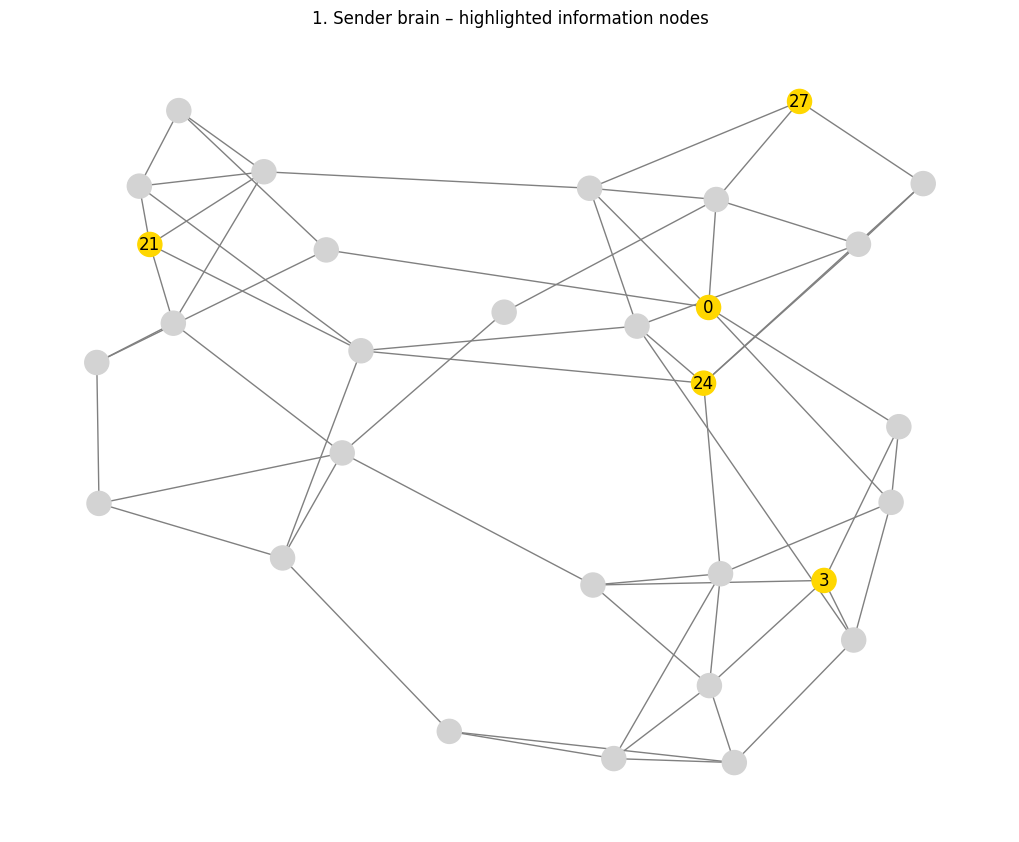

/var/folders/1r/p1_3kg652bbgwr9qm_hgg_pc0000gn/T/ipykernel_32056/3881953054.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


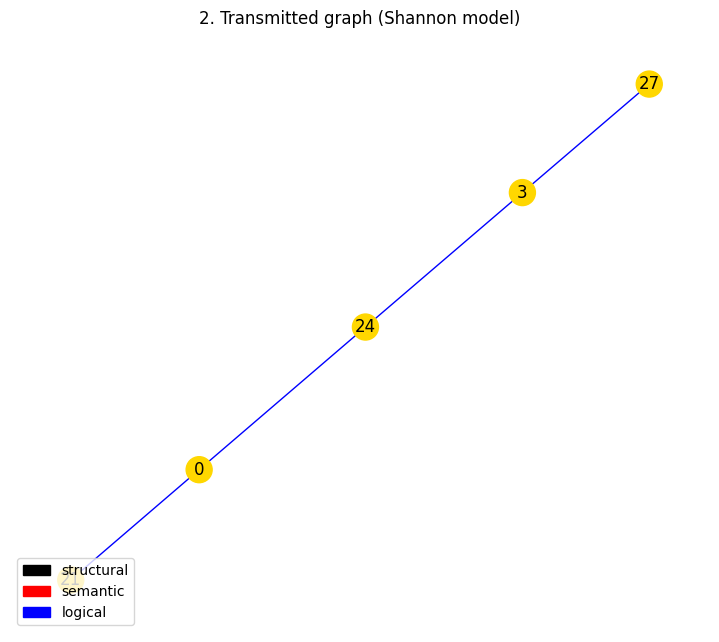

/var/folders/1r/p1_3kg652bbgwr9qm_hgg_pc0000gn/T/ipykernel_32056/3881953054.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


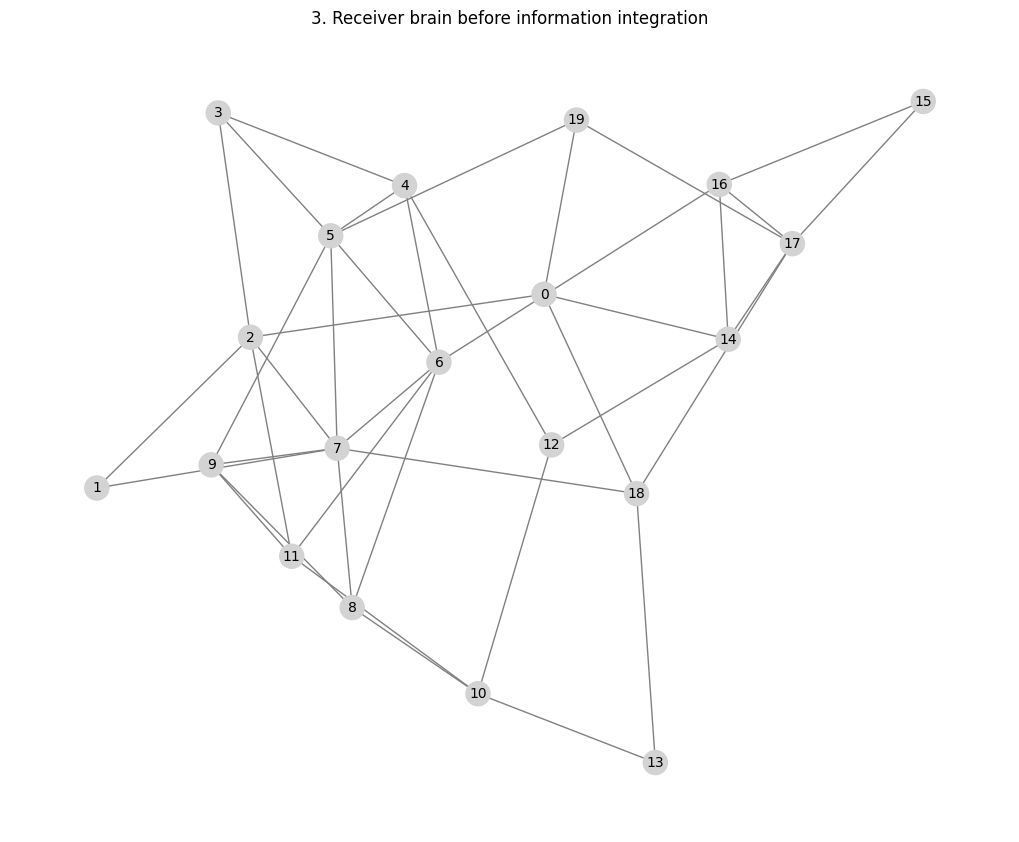

/var/folders/1r/p1_3kg652bbgwr9qm_hgg_pc0000gn/T/ipykernel_32056/3881953054.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


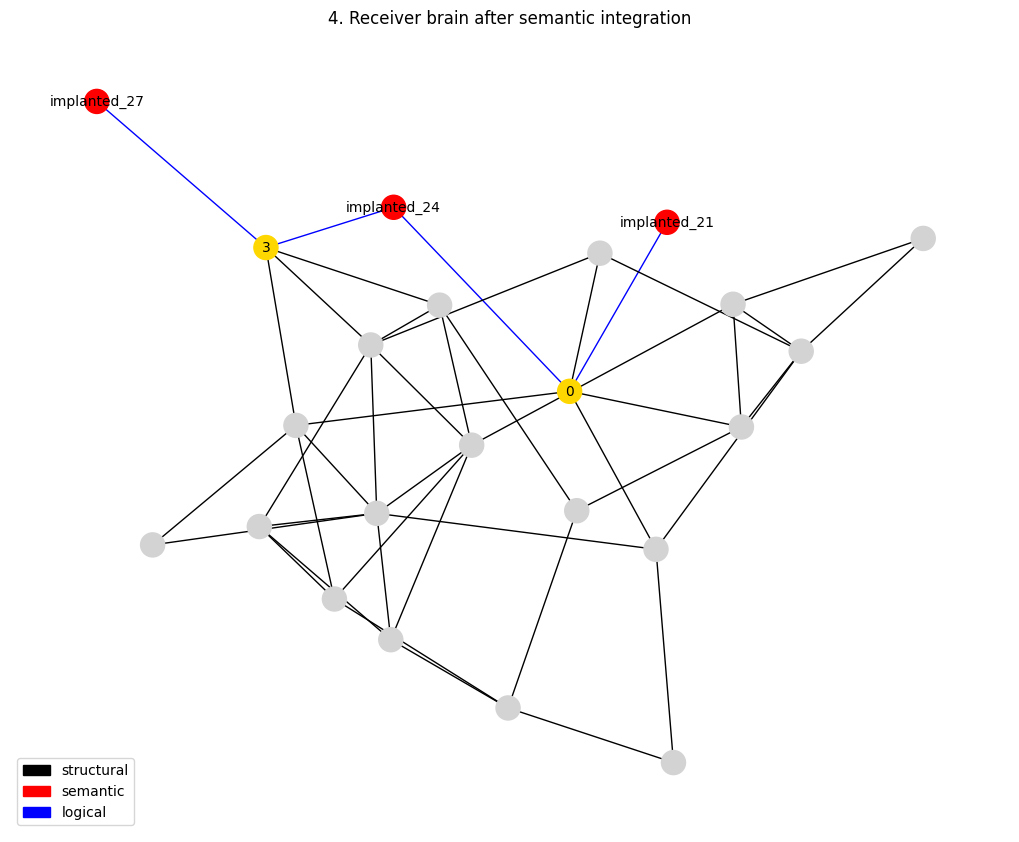

/var/folders/1r/p1_3kg652bbgwr9qm_hgg_pc0000gn/T/ipykernel_32056/3881953054.py:218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


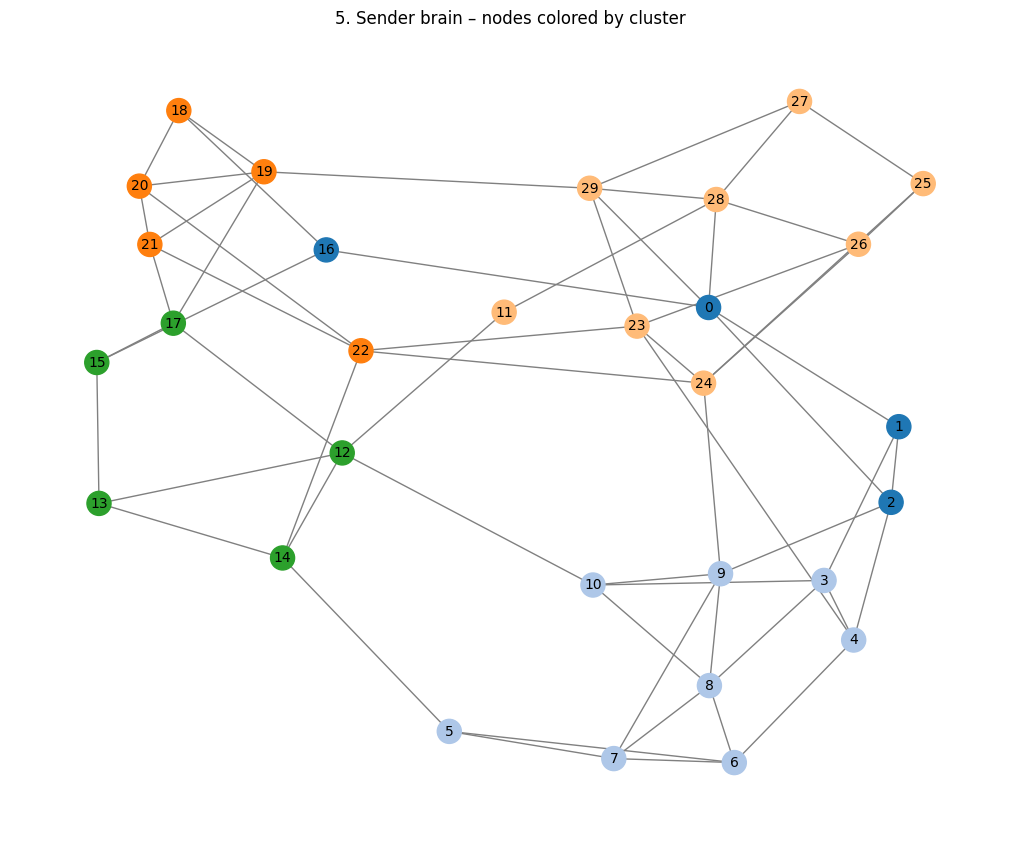

/var/folders/1r/p1_3kg652bbgwr9qm_hgg_pc0000gn/T/ipykernel_32056/3881953054.py:255: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


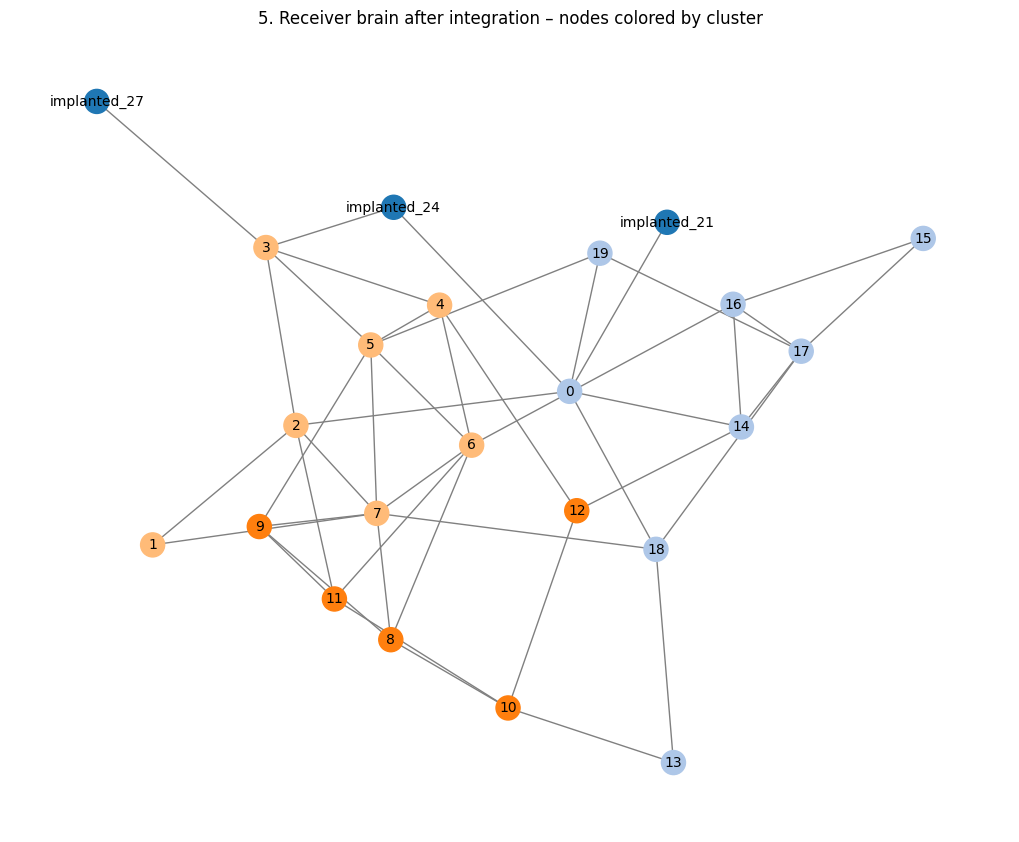

/var/folders/1r/p1_3kg652bbgwr9qm_hgg_pc0000gn/T/ipykernel_32056/1142324644.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


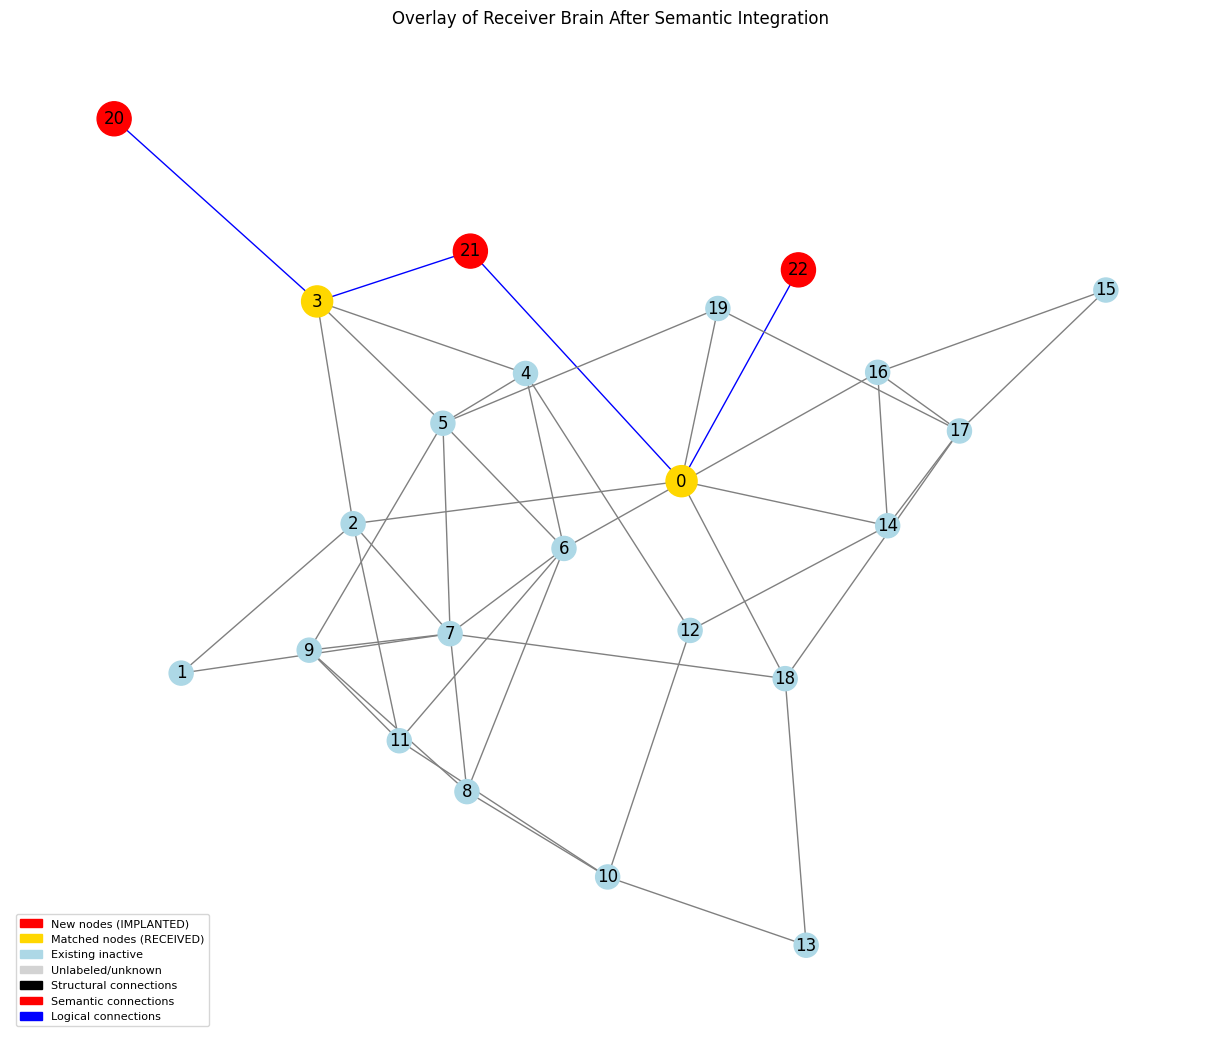

Saved overlay to: report/30_20_5_1_1/brain_state/overlay_brain.png
Newly implanted nodes: 3


In [ ]:
from collections import defaultdict
import copy

# === 1. SENDER: build and annotate brain structure ===
sender_brain = build_brain(config["sender_size"])
detect_brain_clusters(sender_brain)
assign_cluster_embeddings(sender_brain)
assign_predictive_weights_gaussian(sender_brain, mu=0.6, sigma=0.2)

# assign_predictive_weights(sender_brain)
# transform_weights_to_gaussian_profile(sender_brain)  # <- opcjonalnie
export_edge_weights(sender_brain, name="sender_brain")

# === 2. RECEIVER: initial (pre-integration) brain ===
receiver_brain = build_brain(config["receiver_size"])
detect_brain_clusters(receiver_brain)
assign_cluster_embeddings(receiver_brain)

# === 3. MESSAGE: generate information subgraph from sender ===
info = generate_information_subgraph(
    sender_brain, config["transmitting"], chaos_level=config["chaos_level"])

# Dodajemy embeddingi i metadane
for node in info.nodes:
    info.nodes[node]['embedding'] = sender_brain.nodes[node].get('embedding')
    info.nodes[node]['cluster'] = sender_brain.nodes[node].get('cluster', -1)
    info.nodes[node]['label'] = sender_brain.nodes[node].get('label', str(node))

# === 4. TRANSMISSION: simulate traversal of message ===
start_node = list(info.nodes)[0]
transmitted, info_scores, avg_info, transmission_sequence, decision_log = transmit_information_with_contextual_returns(
    info_graph=info,
    start=start_node,
    transmission_prob=config["transmission_prob"]
)
save_decision_log(decision_log)

# Transfer node embeddings into the transmitted graph
for node in transmitted.nodes:
    transmitted.nodes[node]['embedding'] = sender_brain.nodes[node].get('embedding')

# === 5. SHARED LAYOUT: prepare consistent layout for visualization ===
layout_seed = 42
shared_pos = nx.spring_layout(receiver_brain, seed=layout_seed)

# === 6. RECEIVER BEFORE: copy initial state for comparison ===
receiver_brain_before = copy.deepcopy(receiver_brain)
# assign_predictive_weights(receiver_brain_before)
assign_predictive_weights_gaussian(receiver_brain_before, mu=0.6, sigma=0.2)
export_edge_weights(receiver_brain_before, name="receiver_before")

# === 7. RECEIVER AFTER: apply integration (implant or match nodes) ===
receiver_brain_after = copy.deepcopy(receiver_brain_before)
mapping = integrate_into_receiver(
    receiver_brain_after,
    transmitted,
    transmission_sequence=transmission_sequence,
    preserve_semantic_edges=add_semantic_edges
)

# Przenieś embeddingi z transmitowanych do ich odpowiedników po implantacji
for original_node, target_node in mapping.items():
    emb = transmitted.nodes[original_node].get("embedding")
    if emb is not None:
        receiver_brain_after.nodes[target_node]["embedding"] = emb
# assign_predictive_weights(receiver_brain_after)
assign_predictive_weights_gaussian(receiver_brain_after, mu=0.6, sigma=0.2)
export_edge_weights(receiver_brain_after, name="receiver_after")

# === 7.5: compute receiver info scores (AFTER integration) ===
mapped_transmission_sequence = [
    mapping.get(n) for n in transmission_sequence if mapping.get(n) is not None
]

receiver_cluster_sequence = []
receiver_known_clusters = set()
receiver_last_cluster = None
info_scores_receiver = {}

for mapped_node in mapped_transmission_sequence:
    cluster = receiver_brain_after.nodes[mapped_node].get("cluster", -1)
    info_value = compute_node_information_receiver(
        node=mapped_node,
        receiver_graph=receiver_brain_after,
        cluster_sequence=receiver_cluster_sequence,
        known_clusters=receiver_known_clusters,
        last_cluster=receiver_last_cluster
    )
    info_scores_receiver[mapped_node] = info_value
    receiver_cluster_sequence.append(cluster)
    receiver_known_clusters.add(cluster)
    receiver_last_cluster = cluster

# === 8. HEBBIAN RULE: strengthen used edges only ===
used_edges = set()
used_nodes = set()

for i in range(len(transmission_sequence) - 1):
    orig_u = transmission_sequence[i]
    orig_v = transmission_sequence[i + 1]
    u = mapping.get(orig_u, orig_u)
    v = mapping.get(orig_v, orig_v)
    if receiver_brain_after.has_edge(u, v):
        used_edges.add(tuple(sorted((u, v))))
    used_nodes.add(u)
    used_nodes.add(v)

for u, v in used_edges:
    w = receiver_brain_after[u][v].get("weight", 0.0)
    receiver_brain_after[u][v]["weight"] = min(1.0, w * 1.1)

export_edge_weights(receiver_brain_after, name="receiver_after_hebb")

# === 9. WEIGHT DIFFERENCE ANALYSIS ===
def normalized(u, v):
    return tuple(sorted((u, v)))

before_weights = {
    normalized(u, v): d.get("weight", 0.0)
    for u, v, d in receiver_brain_before.edges(data=True)
}
after_weights = {
    normalized(u, v): d.get("weight", 0.0)
    for u, v, d in receiver_brain_after.edges(data=True)
}

all_edges = set(before_weights.keys()) | set(after_weights.keys())
diff_rows = []
for u, v in sorted(all_edges):
    w_before = before_weights.get((u, v), 0.0)
    w_after = after_weights.get((u, v), 0.0)
    if abs(w_after - w_before) > 1e-5:
        diff_rows.append([
            u, v,
            f"{w_before:.4f}",
            f"{w_after:.4f}",
            f"{w_after - w_before:+.4f}"
        ])

save_csv_to_report_dir(
    data_rows=diff_rows,
    header=["Node1", "Node2", "Weight Before", "Weight After", "Change"],
    filename="receiver_weight_differences.csv"
)
print("Saved weight difference analysis to: receiver_weight_differences.csv")

# === 10. SEMANTIC RECLASSIFICATION of IMPLANTED EDGES ===
reclassify_implanted_edges(
    receiver_brain_after,
    transmitted,
    mapping
)

# === 11. FINAL LAYOUT: preserve position across before/after ===
shared_pos = nx.spring_layout(
    receiver_brain_after,
    pos=shared_pos,
    fixed=shared_pos.keys()
)

# === 12. VISUALIZATION ===
visualize_brain_states(
    sender_brain,
    info,
    transmitted,
    receiver_brain_before,
    receiver_brain_after,
    pos=shared_pos
)

visualize_overlay_brain_with_highlight(
    receiver_brain_before,
    receiver_brain_after,
    pos=shared_pos,
    show=True
)

# === 13. REPORT: new implanted nodes ===
new_nodes = set(receiver_brain_after.nodes) - set(receiver_brain_before.nodes)
print(f"Newly implanted nodes: {len(new_nodes)}")

In [2352]:
plot_cluster_distribution(receiver_brain_after,
                          title="Receiver Brain – Cluster Distribution")

Cluster distribution plot saved to: report/30_20_5_1_1/cluster_distribution/cluster_distribution.png


In [ ]:
def plot_info_score_comparison(
    sender_scores,
    receiver_scores,
    receiver_graph,
    title="Sender vs Receiver Info Scores",
    report_root="report",
    filename="info_scores_comparison.png"
):
    """
    Plots and saves a bar chart comparing sender and receiver information scores
    for each node that originated in the sender (based on origin_id).

    Parameters:
        sender_scores (dict): {sender_node_id: score}
        receiver_scores (dict): {receiver_node_id: score}
        receiver_graph (networkx.Graph): Receiver graph with origin_id attributes
        title (str): Title of the chart
        report_root (str): Base directory to store the plot
        filename (str): Filename of the saved plot
    """

    def get_report_subdir(report_root):
        subdir = os.path.join(
            report_root,
            f"{config['sender_size']}_{config['receiver_size']}_{config['transmitting']}_{config['transmission_prob']}_{config['chaos_level']}"
        )
        os.makedirs(subdir, exist_ok=True)
        return subdir

    # Map sender_node_id → receiver_node_id via origin_id
    sender_ids = []
    sender_values = []
    receiver_values = []

    for receiver_node, data in receiver_graph.nodes(data=True):
        origin = data.get("origin_id")
        if origin is not None:
            sender_score = sender_scores.get(origin)
            receiver_score = receiver_scores.get(receiver_node)
            if sender_score is not None and receiver_score is not None:
                sender_ids.append(origin)
                sender_values.append(sender_score)
                receiver_values.append(receiver_score)

    delta_values = [r - s for s, r in zip(sender_values, receiver_values)]

    x = np.arange(len(sender_ids))
    width = 0.3

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(x - width, sender_values, width, label='Sender', alpha=0.75)
    ax.bar(x, receiver_values, width, label='Receiver', alpha=0.75)
    ax.bar(x + width, delta_values, width,
           label='Difference (Receiver - Sender)', alpha=0.6)

    ax.set_xticks(x)
    ax.set_xticklabels(sender_ids)
    ax.set_xlabel("Sender Node ID")
    ax.set_ylabel("Information Score")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()

    save_dir = os.path.join(get_report_subdir(report_root), "info_scores")
    os.makedirs(save_dir, exist_ok=True)
    output_path = os.path.join(save_dir, filename)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Info score comparison plot saved to: {output_path}")


In [2355]:
plot_info_score_comparison(
    sender_scores=info_scores,
    receiver_scores=info_scores_receiver,
    receiver_graph=receiver_brain_after,
    title="Info Score Comparison (Sender vs Receiver)",
    report_root="report"
)

✅ Info score comparison plot saved to: report/30_20_5_1_1/info_scores/info_scores_comparison.png


In [2356]:
def log_transmission_sequence_to_csv(info_graph, transmission_sequence, report_root="report"):
    """
    Logs the transmission sequence to a CSV file with node ID, label, and cluster.

    Parameters:
        info_graph (networkx.Graph): Graph containing transmitted nodes and attributes.
        transmission_sequence (list): Ordered list of transmitted node IDs.
        report_root (str): Base directory for saving the report.
    """
    transmission_log_rows = [
        [i + 1,
         node,
         info_graph.nodes[node].get('label', str(node)),
         info_graph.nodes[node].get('cluster', 'None')]
        for i, node in enumerate(transmission_sequence)
    ]

    return save_csv_to_report_dir(
        data_rows=transmission_log_rows,
        header=["Index", "Node_ID", "Label", "Cluster"],
        filename="transmission_sequence.csv",
        report_root=report_root
    )

log_transmission_sequence_to_csv(info, transmission_sequence, report_root=report_root)

 Zapisano plik CSV do: report/30_20_5_1_1/transmission_sequence.csv


'report/30_20_5_1_1/transmission_sequence.csv'

In [2357]:
import os
import numpy as np
import matplotlib.pyplot as plt


def plot_predictive_weights_histogram(
    graph,
    filename_csv="predictive_weights_histogram.csv",
    filename_png="predictive_weights_histogram.png",
    title="Predictive Weight Distribution (cosine similarity)",
    bins=20
):
    """
    Generates and saves a histogram of predictive weights from the given graph.

    Both a PNG plot and a CSV summary are saved in a 'predictive_weight' subfolder 
    inside the specified report_root directory.

    Parameters:
        graph (networkx.Graph): Graph with 'weight' attributes on its edges.
        filename_csv (str): Name of the output CSV file (default generic name).
        filename_png (str): Name of the output PNG file (default generic name).
        title (str): Title of the histogram plot.
        report_root (str): Root directory where the 'predictive_weight' folder will be created.
        bins (int): Number of bins in the histogram.
    """
    # 1. Extract weights
    weights = [d.get("weight", 0) for _, _, d in graph.edges(data=True)]
    hist_values, bin_edges = np.histogram(weights, bins=bins)

    hist_rows = [
        [f"{bin_edges[i]:.4f} – {bin_edges[i+1]:.4f}", int(hist_values[i])]
        for i in range(len(hist_values))
    ]

    # 2. Create output directory
    output_dir = os.path.join(get_report_subdir(
        report_root), "predictive_weight")
    os.makedirs(output_dir, exist_ok=True)

    # 3. Save CSV
    csv_path = os.path.join(output_dir, filename_csv)
    with open(csv_path, "w", encoding="utf-8") as f:
        f.write("Bin Range,Edge Count\n")
        for row in hist_rows:
            f.write(f"{row[0]},{row[1]}\n")

    # 4. Plot and save PNG
    plt.figure(figsize=(8, 5))
    plt.hist(weights, bins=bins, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Weight")
    plt.ylabel("Edge Count")
    plt.grid(True)
    plt.tight_layout()

    png_path = os.path.join(output_dir, filename_png)
    plt.savefig(png_path)
    plt.show()

    print(f"PNG saved: {png_path}")
    print(f"CSV saved: {csv_path}")

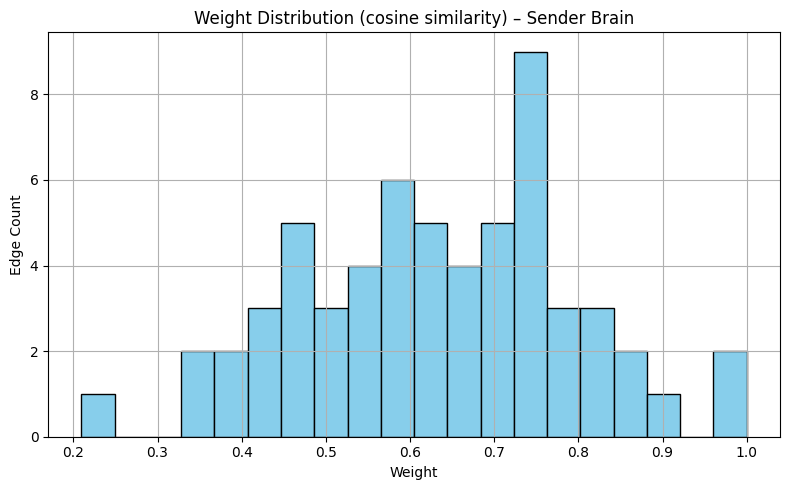

PNG saved: report/30_20_5_1_1/predictive_weight/predictive_weights_histogram_sender.png
CSV saved: report/30_20_5_1_1/predictive_weight/predictive_weights_histogram.csv


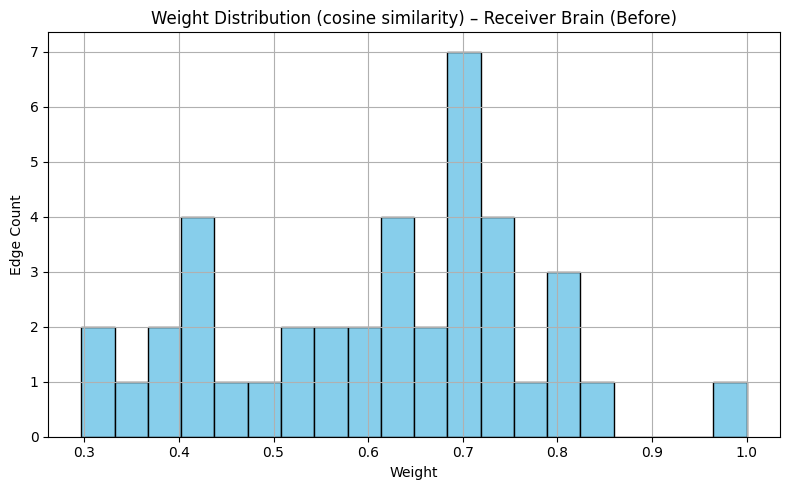

PNG saved: report/30_20_5_1_1/predictive_weight/predictive_weights_histogram_before.png
CSV saved: report/30_20_5_1_1/predictive_weight/predictive_weights_histogram.csv


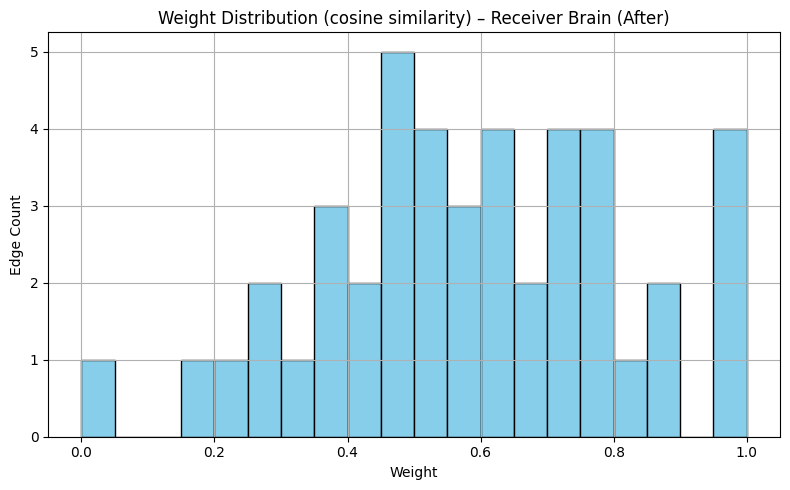

PNG saved: report/30_20_5_1_1/predictive_weight/predictive_weights_histogram_after.png
CSV saved: report/30_20_5_1_1/predictive_weight/predictive_weights_histogram.csv


In [2358]:
plot_predictive_weights_histogram(
    sender_brain,
    filename_png="predictive_weights_histogram_sender.png",
    title="Weight Distribution (cosine similarity) – Sender Brain",
)

plot_predictive_weights_histogram(
    receiver_brain_before,
    filename_png="predictive_weights_histogram_before.png",
    title="Weight Distribution (cosine similarity) – Receiver Brain (Before)",
)

plot_predictive_weights_histogram(
    receiver_brain_after,
    filename_png="predictive_weights_histogram_after.png",
    title="Weight Distribution (cosine similarity) – Receiver Brain (After)",
)

In [2359]:
import os
import numpy as np
import matplotlib.pyplot as plt


def plot_weight_histogram_comparison(
    graph_before,
    graph_after,
    filename_csv_before="predictive_weights_histogram_receiver_before.csv",
    filename_csv_after="predictive_weights_histogram_receiver_after.csv",
    filename_png="predictive_weights_comparison_receiver.png",
    report_root="report",
    bins=20
):
    """
    Plots and saves a comparison of predictive weight histograms
    before and after integration.

    All outputs are saved in a 'compare_weight/' subfolder inside the report_root.

    Parameters:
        graph_before (networkx.Graph): The graph before integration.
        graph_after (networkx.Graph): The graph after integration.
        filename_csv_before (str): Output CSV filename for pre-integration weights.
        filename_csv_after (str): Output CSV filename for post-integration weights.
        filename_png (str): Output PNG filename for the comparison plot.
        report_root (str): Root directory for saving reports.
        bins (int): Number of histogram bins.
    """
    # === 1. Create output directory ===
    output_dir = os.path.join(get_report_subdir(report_root), "compare_weight")
    os.makedirs(output_dir, exist_ok=True)

    # === 2. Extract weights and compute histograms ===
    weights_before = [d.get("weight", 0.0)
                      for _, _, d in graph_before.edges(data=True)]
    weights_after = [d.get("weight", 0.0)
                     for _, _, d in graph_after.edges(data=True)]

    hist_before, bins_b = np.histogram(weights_before, bins=bins)
    hist_after, bins_a = np.histogram(weights_after, bins=bins)

    # === 3. Save histogram data to CSV ===
    hist_rows_before = [
        [f"{bins_b[i]:.4f} – {bins_b[i+1]:.4f}", int(hist_before[i])]
        for i in range(len(hist_before))
    ]
    hist_rows_after = [
        [f"{bins_a[i]:.4f} – {bins_a[i+1]:.4f}", int(hist_after[i])]
        for i in range(len(hist_after))
    ]

    csv_path_before = os.path.join(output_dir, filename_csv_before)
    csv_path_after = os.path.join(output_dir, filename_csv_after)

    with open(csv_path_before, "w", encoding="utf-8") as f:
        f.write("Bin Range,Edge Count\n")
        for row in hist_rows_before:
            f.write(f"{row[0]},{row[1]}\n")

    with open(csv_path_after, "w", encoding="utf-8") as f:
        f.write("Bin Range,Edge Count\n")
        for row in hist_rows_after:
            f.write(f"{row[0]},{row[1]}\n")

    # === 4. Plot the histogram comparison ===
    plt.figure(figsize=(8, 5))
    plt.hist(weights_before, bins=bins, color='lightgray', edgecolor='black',
             label="Before integration", alpha=0.7)
    plt.hist(weights_after, bins=bins, color='lightcoral', edgecolor='black',
             label="After integration", alpha=0.7)

    plt.title("Predictive Weight Distribution – Receiver (Before vs After)")
    plt.xlabel("Weight (cosine similarity)")
    plt.ylabel("Number of Edges")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # === 5. Save the plot as PNG ===
    png_path = os.path.join(output_dir, filename_png)
    plt.savefig(png_path)
    plt.show()

    print(f"PNG saved: {png_path}")
    print(f"CSV (before) saved: {csv_path_before}")
    print(f"CSV (after) saved: {csv_path_after}")

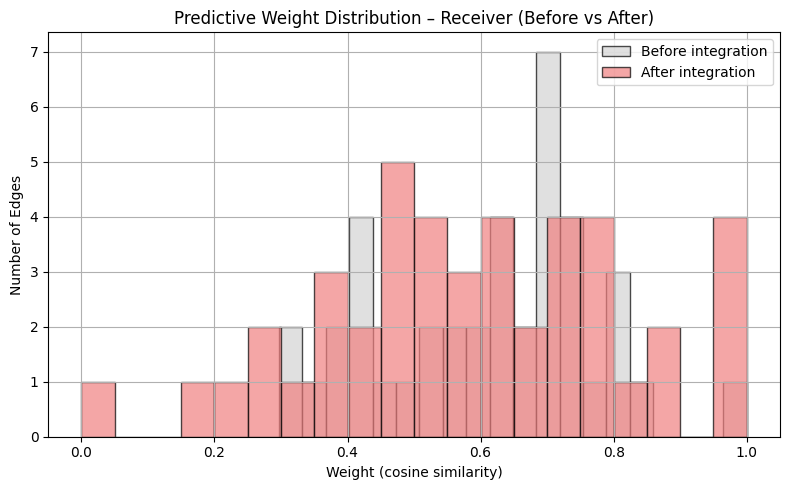

PNG saved: report/30_20_5_1_1/compare_weight/predictive_weights_comparison_receiver.png
CSV (before) saved: report/30_20_5_1_1/compare_weight/predictive_weights_histogram_receiver_before.csv
CSV (after) saved: report/30_20_5_1_1/compare_weight/predictive_weights_histogram_receiver_after.csv


In [2360]:
plot_weight_histogram_comparison(
    receiver_brain_before,
    receiver_brain_after,
    report_root=report_root
)

In [2361]:
import os
import csv
import matplotlib.pyplot as plt

def analyze_information_scores(info_scores, avg_info, info_graph, report_root="report", verbose=True):
    """
    Saves information score data to CSV and generates a bar plot.

    Parameters:
        info_scores (dict): Mapping from node → information (in bits).
        avg_info (float): Average information score.
        info_graph (networkx.Graph): Graph containing the nodes with 'label'.
        report_root (str): Directory where reports will be saved.
        verbose (bool): Whether to print progress and summaries.

    Returns:
        dict: Paths to the CSV and PNG files, list of rows, and average information value.
    """
    # Paths
    save_dir = os.path.join(get_report_subdir(report_root), "info_scores")
    os.makedirs(save_dir, exist_ok=True)
    csv_path = os.path.join(save_dir, "info_scores.csv")
    plot_path = os.path.join(save_dir, "info_plot.png")

    # Data to save
    data_rows = [
        (info_graph.nodes[node].get('label', str(node)), score)
        for node, score in info_scores.items()
    ]

    # Verbose log
    if verbose:
        print("Information transmitted by nodes:")
        for label, score in data_rows:
            print(f" - {label}: {score:.3f} bits")
        print(f"\nAverage information score: {avg_info:.3f} bits")

    # CSV export
    with open(csv_path, "w", newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["Node_Label", "Information_Bits"])
        writer.writerows(data_rows)
    if verbose:
        print(f"CSV saved to: {csv_path}")

    # Plot
    labels, scores = zip(*data_rows) if data_rows else ([], [])
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(scores)), scores, color='gold', edgecolor='black')
    plt.axhline(avg_info, color='red', linestyle='--', label=f'Average: {avg_info:.3f} bits')
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.xlabel("Node label")
    plt.ylabel("Information (bits)")
    plt.title("Amount of information contributed by transmitted nodes")
    plt.legend()
    plt.grid(axis='y', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.close()
    if verbose:
        print(f"Plot saved to: {plot_path}")

    return {
        "csv_path": csv_path,
        "plot_path": plot_path,
        "data_rows": data_rows,
        "avg_info": avg_info
    }


In [2362]:
analyze_information_scores(info_scores, avg_info, info)

Information transmitted by nodes:
 - 27: 3.500 bits
 - 3: 3.792 bits
 - 24: 2.792 bits
 - 0: 3.792 bits
 - 21: 3.500 bits

Average information score: 3.475 bits
CSV saved to: report/30_20_5_1_1/info_scores/info_scores.csv
Plot saved to: report/30_20_5_1_1/info_scores/info_plot.png


{'csv_path': 'report/30_20_5_1_1/info_scores/info_scores.csv',
 'plot_path': 'report/30_20_5_1_1/info_scores/info_plot.png',
 'data_rows': [('27', 3.5),
  ('3', 3.792481250360578),
  ('24', 2.792481250360578),
  ('0', 3.792481250360578),
  ('21', 3.5)],
 'avg_info': 3.475488750216347}

In [2363]:
def transmit_information_with_contextual_returns(
    info_graph,
    transmission_prob,
    start=None,
    cluster_attr="cluster"
):
    """
    Transmits information with Shannon-style noise:
    Each node has a probability of being successfully transmitted.
    Structure remains intact, but nodes may be skipped due to 'channel loss'.
    """
    from collections import deque

    transmitted_nodes = []
    transmission_sequence = []
    decision_log = []
    info_scores = {}
    cluster_sequence = []
    known_clusters = set()
    last_cluster = None
    visited = set()

    # === Logiczna sekwencja między węzłami informacji (np. logiczna fala) ===
    info_nodes = list(info_graph.nodes)
    for i in range(len(info_nodes) - 1):
        u, v = info_nodes[i], info_nodes[i + 1]
        if not info_graph.has_edge(u, v):
            info_graph.add_edge(u, v, type="logical")

    # Ustal punkt startowy
    all_nodes = list(info_graph.nodes)
    if start is None:
        start = all_nodes[0]

    queue = deque([start])

    while queue:
        node = queue.popleft()
        if node in visited:
            continue
        visited.add(node)

        # === Szansa na utratę informacji (Shannon noise) ===
        success = random.random() <= transmission_prob
        decision_log.append({
            "node": node,
            "accepted": success,
            "reason": "transmission_prob",
            "random_value": round(random.random(), 4)
        })

        if not success:
            continue  # node został utracony w kanale

        # === Zarejestruj jako przesłany ===
        cluster = info_graph.nodes[node].get(cluster_attr, -1)
        info_value = compute_node_information(
            node=node,
            graph=info_graph,
            cluster_sequence=cluster_sequence,
            known_clusters=known_clusters,
            last_cluster=last_cluster
        )

        transmitted_nodes.append(node)
        transmission_sequence.append(node)
        info_scores[node] = info_value
        cluster_sequence.append(cluster)
        known_clusters.add(cluster)
        last_cluster = cluster

        # === Dodaj sąsiadów do kolejki (kolejność dowolna: DFS lub BFS) ===
        neighbors = list(info_graph.neighbors(node))
        random.shuffle(neighbors)
        queue.extend([n for n in neighbors if n not in visited])

    # === Budowa podgrafu z przesłanych węzłów ===
    transmitted_graph = info_graph.subgraph(transmitted_nodes).copy()
    for n in transmitted_graph.nodes:
        transmitted_graph.nodes[n]["state"] = "TRANSMITTED"

    avg_info = np.mean(list(info_scores.values())) if info_scores else 0.0

    return transmitted_graph, info_scores, avg_info, transmission_sequence, decision_log


In [ ]:
import os
import json
import csv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
from networkx.algorithms.similarity import graph_edit_distance
from sklearn.cluster import KMeans


def full_graph_analysis(
    sender_brain,
    info_graph,
    transmitted_graph,
    receiver_brain_before,
    receiver_brain_after,
    info_scores,
    avg_info,
    transmission_sequence,
    decision_log,
    mapping,
    config,
    free_energy,
    dissociation_report,
    report_root="report"
):
    base_dir = os.path.join(
        report_root,
        f"{config['sender_size']}_{config['receiver_size']}_{config['transmitting']}_{config['transmission_prob']}_{config['chaos_level']}"
    )
    os.makedirs(base_dir, exist_ok=True)

    def _save_csv(data_rows, header, filename, plot_title=None, xlabel=None, ylabel=None):
        path = os.path.join(base_dir, "analysis", filename)
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "w", newline='', encoding="utf-8") as f:
            writer = csv.writer(f)
            if header:
                writer.writerow(header)
            writer.writerows(data_rows)

        if plot_title and data_rows:
            plt.figure(figsize=(10, 5))
            x = [row[0] for row in data_rows]
            y = [row[1] for row in data_rows]
            plt.bar(x, y, color='skyblue', edgecolor='black')
            plt.title(plot_title)
            plt.xlabel(xlabel or "")
            plt.ylabel(ylabel or "")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plot_path = path.replace(".csv", ".png")
            plt.savefig(plot_path)
            plt.close()

        return path

    def _save_json(data, filename):
        path = os.path.join(base_dir, "analysis", filename)
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=4)
        return path

    # === Informacja ===
    info_rows = [(info_graph.nodes[n]['label'], score)
                 for n, score in info_scores.items()]
    _save_csv(info_rows, ["Node_Label", "Information_Bits"], "info_scores.csv",
              plot_title="Information per Node", xlabel="Node", ylabel="Information (bits)")

    # === Histogram informacji ===
    scores = [r[1] for r in info_rows]
    hist_values, hist_bins = np.histogram(scores, bins=10)
    hist_rows = [
        [f"{hist_bins[i]:.4f} – {hist_bins[i+1]:.4f}", int(hist_values[i])]
        for i in range(len(hist_values))
    ]
    _save_csv(hist_rows, ["Bin Range", "Edge Count"], "info_histogram.csv",
              plot_title="Information Histogram", xlabel="Bin Range", ylabel="Edge Count")

    # === Transmisja ===
    transmission_rows = [
        [i + 1, n, info_graph.nodes[n]['label'],
            info_graph.nodes[n].get('cluster', -1)]
        for i, n in enumerate(transmission_sequence)
    ]
    _save_csv(transmission_rows, ["Step", "Node", "Label", "Cluster"], "transmission_sequence.csv",
              plot_title="Transmission Order", xlabel="Step", ylabel="Node ID")

    _save_json(decision_log, "decision_log.json")

    # === Similarity ===
    label_map_sender = nx.get_node_attributes(sender_brain, 'label')
    label_map_receiver = nx.get_node_attributes(receiver_brain_after, 'label')
    label_to_sender = {v: k for k, v in label_map_sender.items()}
    label_to_receiver = {v: k for k, v in label_map_receiver.items()}
    shared_labels = set(label_to_sender) & set(label_to_receiver)

    jaccard_scores = []
    for label in shared_labels:
        u, v = label_to_sender[label], label_to_receiver[label]
        neighbors_u = set(label_map_sender.get(n)
                          for n in sender_brain.neighbors(u) if n in label_map_sender)
        neighbors_v = set(label_map_receiver.get(
            n) for n in receiver_brain_after.neighbors(v) if n in label_map_receiver)
        intersection = neighbors_u & neighbors_v
        union = neighbors_u | neighbors_v
        if union:
            jaccard_scores.append(len(intersection) / len(union))

    avg_jaccard = np.mean(jaccard_scores) if jaccard_scores else 0.0

    try:
        edit_dist_iter = graph_edit_distance(
            transmitted_graph, receiver_brain_after, timeout=5)
        edit_distance = next(edit_dist_iter)
    except:
        edit_distance = None

    # === Reinterpretacja ===
    reinterpret_count = sum(
        1 for label in shared_labels
        if sender_brain.degree[label_to_sender[label]] != receiver_brain_after.degree[label_to_receiver[label]]
    )

    # === Implanted nodes ===
    implanted_nodes = [n for n, d in receiver_brain_after.nodes(
        data=True) if d.get("state") == "IMPLANTED"]
    pct_implanted = len(implanted_nodes) / \
        receiver_brain_after.number_of_nodes() * 100

    # === KMeans clustering ===
    degrees = np.array([[d] for _, d in receiver_brain_after.degree()])
    kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto').fit(degrees)
    cluster_counts = np.bincount(kmeans.labels_)
    cluster_rows = [(f"Cluster {i}", c) for i, c in enumerate(cluster_counts)]
    _save_csv(cluster_rows, ["Cluster", "Count"], "receiver_kmeans_clusters.csv",
              plot_title="Receiver KMeans Clusters", xlabel="Cluster", ylabel="Count")

    # === Dissociation report + Free Energy ===
    dissociation_metrics = {
        "risk_score": dissociation_report.get("risk_score_percent"),
        "risk_notes": dissociation_report.get("risk_analysis"),
        "main_component": {
            "size": dissociation_report.get("main_component_size"),
            "%implanted": dissociation_report.get("main_component_%implanted"),
            "avg_degree": dissociation_report.get("main_component_avg_degree")
        },
        "isolated_clusters": dissociation_report.get("isolated_implanted_structures", [])
    }

    # === Wynik ===
    result = {
        "general": {
            "sender_nodes": sender_brain.number_of_nodes(),
            "receiver_nodes": receiver_brain_after.number_of_nodes(),
            "implanted_nodes": len(implanted_nodes),
            "implanted_percentage": round(pct_implanted, 2),
            "avg_info": avg_info
        },
        "similarity": {
            "avg_jaccard": round(avg_jaccard, 3),
            "edit_distance": edit_distance,
            "reinterpreted_shared_nodes": reinterpret_count
        },
        "dissociation": dissociation_metrics,
        "free_energy": round(free_energy, 4) if free_energy is not None else None,
        "meta": {
            "timestamp": datetime.now().isoformat()
        }
    }

    _save_json(result, "full_analysis.json")
    print("[✔] full_analysis.json saved.")
    return result

In [2365]:
import json
import csv
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import Counter
from datetime import datetime
from networkx.algorithms.similarity import graph_edit_distance
from sklearn.cluster import KMeans
import os

def graph_analysis(
	graph_a,
	graph_b,
	info_graph,
	info_scores,
	avg_info,
	config,
	report_root="report",
	name="default"
):
	base_dir = os.path.join(report_root, name)
	os.makedirs(base_dir, exist_ok=True)

	def _save_csv(data_rows, header, filename):
		path = os.path.join(base_dir, "analysis", filename)
		os.makedirs(os.path.dirname(path), exist_ok=True)
		with open(path, "w", newline='', encoding="utf-8") as f:
			writer = csv.writer(f)
			if header:
				writer.writerow(header)
			writer.writerows(data_rows)
		return path

	save_path = os.path.join(base_dir, "before_after_analysis.json")
	plot_path = os.path.join(base_dir, "info_plot.png")
	hist_path = os.path.join(base_dir, "plot_info_hist.png")

	labels_a = set(nx.get_node_attributes(graph_a, 'label').values())
	labels_b = set(nx.get_node_attributes(graph_b, 'label').values())

	common_labels = labels_a & labels_b
	only_in_a = labels_a - labels_b
	only_in_b = labels_b - labels_a

	stats = {
		"graph_a": {
			"nodes": graph_a.number_of_nodes(),
			"edges": graph_a.number_of_edges(),
			"avg_degree": sum(dict(graph_a.degree()).values()) / graph_a.number_of_nodes(),
			"density": nx.density(graph_a)
		},
		"graph_b": {
			"nodes": graph_b.number_of_nodes(),
			"edges": graph_b.number_of_edges(),
			"avg_degree": sum(dict(graph_b.degree()).values()) / graph_b.number_of_nodes(),
			"density": nx.density(graph_b)
		}
	}

	info_rows = [(info_graph.nodes[node]['label'], score) for node, score in info_scores.items()]
	_save_csv(info_rows, ["Node_Label", "Information_Bits"], "info_scores.csv")

	labels = [row[0] for row in info_rows]
	scores = [row[1] for row in info_rows]

	plt.figure(figsize=(10, 5))
	plt.bar(labels, scores, color='gold', edgecolor='black')
	plt.axhline(avg_info, color='red', linestyle='--', label=f'Average: {avg_info:.3f} bits')
	plt.xlabel("Node ID")
	plt.ylabel("Information (bits)")
	plt.title("Information carried by transmitted nodes")
	plt.legend()
	plt.grid(axis='y', linestyle=':', alpha=0.5)
	plt.tight_layout()
	plt.savefig(plot_path)
	plt.close()

	plt.figure(figsize=(8, 4))
	hist_counts, hist_bins, _ = plt.hist(scores, bins=10, color='skyblue', edgecolor='black')
	plt.xlabel("Information (bits)")
	plt.ylabel("Number of nodes")
	plt.title("Histogram of information amount")
	for count, left, right in zip(hist_counts, hist_bins[:-1], hist_bins[1:]):
		plt.text((left + right) / 2, count, str(int(count)), ha='center', va='bottom')
	plt.tight_layout()
	plt.savefig(hist_path)
	plt.close()

	hist_csv_rows = [
		[f"{hist_bins[i]:.4f} – {hist_bins[i+1]:.4f}", int(hist_counts[i])]
		for i in range(len(hist_counts))
	]
	_save_csv(hist_csv_rows, ["Bin_Range", "Count"], "info_histogram.csv")

	labels_map_a = nx.get_node_attributes(graph_a, 'label')
	labels_map_b = nx.get_node_attributes(graph_b, 'label')
	label_to_a = {v: k for k, v in labels_map_a.items()}
	label_to_b = {v: k for k, v in labels_map_b.items()}
	shared_labels = set(label_to_a) & set(label_to_b)
	jaccard_scores = []

	for label in shared_labels:
		a_node = label_to_a[label]
		b_node = label_to_b[label]
		a_labels = {labels_map_a[n] for n in graph_a.neighbors(a_node) if n in labels_map_a}
		b_labels = {labels_map_b[n] for n in graph_b.neighbors(b_node) if n in labels_map_b}
		union = a_labels | b_labels
		intersection = a_labels & b_labels
		if union:
			jaccard_scores.append(len(intersection) / len(union))

	avg_jaccard = np.mean(jaccard_scores) if jaccard_scores else 0.0

	try:
		edit_dist_iter = graph_edit_distance(graph_a, graph_b, timeout=10)
		edit_dist = next(edit_dist_iter) if edit_dist_iter else None
	except:
		edit_dist = len(set(graph_a.edges) ^ set(graph_b.edges))

	degrees = np.array([[d] for _, d in graph_b.degree()])
	kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto').fit(degrees)
	cluster_distribution = np.bincount(kmeans.labels_)
	_save_csv([(f"Cluster {i}", count) for i, count in enumerate(cluster_distribution)], ["Cluster", "Node_Count"], "graph_b_cluster_distribution.csv")

	reinterpretation_count = sum(
		1 for label in shared_labels
		if graph_a.degree[label_to_a[label]] != graph_b.degree[label_to_b[label]]
	)

	full_result = {
		"Basic comparison": {
			"Common labels": len(common_labels),
			"Only in graph A": len(only_in_a),
			"Only in graph B": len(only_in_b),
			"Graph statistics": stats
		},
		"Information scores": {
			"avg_info": avg_info,
			"scores": dict(info_rows),
			"histogram_bins": hist_counts.tolist()
		},
		"Advanced analysis": {
			"Avg Jaccard similarity": round(avg_jaccard, 3),
			"Graph edit distance": edit_dist,
			"Graph B clusters (by degree, k=3)": cluster_distribution.tolist(),
			"Reinterpreted shared nodes": reinterpretation_count
		},
		"meta": {
			"timestamp": datetime.now().isoformat()
		}
	}

	with open(save_path, "w", encoding='utf-8') as f:
		json.dump(full_result, f, indent=4)

	print("GRAPH ANALYSIS SUMMARY")
	print(f"Common labels: {len(common_labels)}")
	print(f"Only in graph A: {len(only_in_a)}")
	print(f"Only in graph B: {len(only_in_b)}")
	print(f"Avg info: {avg_info:.3f} bits")
	print(f"Avg Jaccard similarity: {avg_jaccard:.3f}")
	print(f"Graph edit distance: {edit_dist}")
	print(f"Reinterpreted nodes: {reinterpretation_count}")
	print("Cluster distribution:", cluster_distribution.tolist())
	print(f"Full analysis saved to {save_path}\n")

	return full_result

In [2366]:
results = graph_analysis(
    graph_a=sender_brain,
    graph_b=receiver_brain_after,
    info_graph=info,
    info_scores=info_scores,
    avg_info=avg_info,
    config=config
)

GRAPH ANALYSIS SUMMARY
Common labels: 20
Only in graph A: 10
Only in graph B: 3
Avg info: 3.475 bits
Avg Jaccard similarity: 0.289
Graph edit distance: 70
Reinterpreted nodes: 17
Cluster distribution: [11, 8, 4]
Full analysis saved to report/default/before_after_analysis.json



In [2367]:
results = graph_analysis(
    graph_a=receiver_brain_before,
    graph_b=receiver_brain_after,
    info_graph=info,
    info_scores=info_scores,
    avg_info=avg_info,
    config=config
)

GRAPH ANALYSIS SUMMARY
Common labels: 20
Only in graph A: 0
Only in graph B: 3
Avg info: 3.475 bits
Avg Jaccard similarity: 0.963
Graph edit distance: 4
Reinterpreted nodes: 2
Cluster distribution: [11, 8, 4]
Full analysis saved to report/default/before_after_analysis.json



In [2368]:
import os
import json
import networkx as nx


def analyze_dissociation(receiver_brain_after, report_root="report"):
    """
    Performs a structural dissociation analysis on the receiver's brain graph
    after information transmission. Identifies isolated implant clusters,
    evaluates global coherence, and computes a dissociation risk score.

    Parameters:
        receiver_brain_after (networkx.Graph): The brain graph after message reception.
        report_root (str): Root directory for saving the report.

    Returns:
        dict: A detailed summary of the dissociation analysis.
    """

    # === Basic Metrics ===
    total_nodes = receiver_brain_after.number_of_nodes()
    total_implanted = sum(1 for _, d in receiver_brain_after.nodes(
        data=True) if d.get("state") == "IMPLANTED")
    total_received = sum(1 for _, d in receiver_brain_after.nodes(
        data=True) if d.get("state") == "RECEIVED")
    implant_pct_total = (total_implanted / total_nodes) * \
        100 if total_nodes else 0

    # === Component Analysis ===
    components = list(nx.connected_components(receiver_brain_after))
    component_info = []

    for comp in components:
        subgraph = receiver_brain_after.subgraph(comp)
        size = len(comp)
        implanted_count = sum(
            1 for n in comp if receiver_brain_after.nodes[n].get("state") == "IMPLANTED")
        percent_implanted = (implanted_count / size) * 100 if size else 0
        avg_degree = sum(dict(subgraph.degree()).values()) / \
            size if size else 0

        component_info.append({
            "size": size,
            "implanted": implanted_count,
            "percent_implanted": round(percent_implanted, 2),
            "avg_degree": round(avg_degree, 2)
        })

    component_info.sort(key=lambda x: x["size"], reverse=True)
    main_component = component_info[0] if component_info else {}

    isolated_implants = [
        comp for comp in component_info[1:]
        if comp["size"] >= 10 and comp["percent_implanted"] >= 80 and comp["avg_degree"] < 2.5
    ]

    # === Risk Scoring ===
    risk_score = 0
    risk_notes = []

    if implant_pct_total > 50:
        risk_score += 20
        risk_notes.append(
            "High implant dominance across entire structure (>50%)")

    if total_received < 5:
        risk_score += 20
        risk_notes.append("Very low number of actively received nodes (<5)")

    if main_component.get("percent_implanted", 0) > 60:
        risk_score += 20
        risk_notes.append("Main component is implant-dominant (>60%)")

    if main_component.get("avg_degree", 0) < 3.0:
        risk_score += 10
        risk_notes.append(
            "Main component has weak internal connectivity (avg_degree < 3)")

    if isolated_implants:
        risk_score += 20
        risk_notes.append("Presence of isolated implant clusters")

    if len(components) > 20:
        risk_score += 10
        risk_notes.append("High structural fragmentation (components > 20)")

    # === Final Result Summary ===
    result = {
        "total_nodes": total_nodes,
        "total_implanted": total_implanted,
        "total_received": total_received,
        "implant_pct_total": round(implant_pct_total, 2),
        "main_component_size": main_component.get("size", 0),
        "main_component_%implanted": main_component.get("percent_implanted", 0),
        "main_component_avg_degree": main_component.get("avg_degree", 0),
        "isolated_implanted_structures": isolated_implants,
        "risk_score_percent": min(risk_score, 100),
        "risk_analysis": risk_notes
    }

    # === Save Report ===
    save_dir = os.path.join(
        get_report_subdir(report_root), "dissociation_analysis"
    )
    os.makedirs(save_dir, exist_ok=True)
    output_path = os.path.join(save_dir, "dissociation_analysis.json")

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(result, f, indent=4)

    print(f"Dissociation analysis saved to: {output_path}")
    return result

In [ ]:
dissociation_report = analyze_dissociation(receiver_brain_after)

In [2370]:
# %% Save Configuration
import os
import json

config = {
    "sender_size": config["sender_size"],
    "receiver_size": config["receiver_size"],
    "transmitting": config["transmitting"],
    "transmission_prob": config["transmission_prob"],
    "chaos_level": config["chaos_level"]
}

save_dir = os.path.join(
    get_report_subdir(report_root)
)
os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

In [2371]:
# %% Shannon Transmission Path (Baseline)

import networkx as nx


def transmit_shannon_path(info_graph):
    """
    Simulates a linear transmission path (Shannon-style) from sender to receiver.
    Edges are added sequentially without backtracking or predictive evaluation.
    """
    nodes = list(info_graph.nodes)
    G = nx.Graph()
    for n in nodes:
        G.add_node(n, **info_graph.nodes[n])
    for i in range(len(nodes) - 1):
        G.add_edge(nodes[i], nodes[i + 1], weight=1.0, type="shannon")
    return G, nodes

In [2372]:
# Wygenerowanie grafu transmisji liniowej
shannon_graph, shannon_sequence = transmit_shannon_path(info)

# Przykładowy podgląd:
print("Kolejność przesłanych węzłów:", shannon_sequence)
print("Liczba krawędzi w grafie Shannon:", shannon_graph.number_of_edges())

Kolejność przesłanych węzłów: [27, 3, 24, 0, 21]
Liczba krawędzi w grafie Shannon: 4


In [ ]:
# %% Free Energy (Friston) Calculation

from scipy.spatial.distance import cosine


def compute_free_energy(emb_u, emb_v):
    """
    Calculates predictive error using cosine distance between embeddings.
    Lower value → better prediction; 1.0 indicates maximal mismatch.
    """
    if emb_u is None or emb_v is None:
        return 1.0
    return cosine(emb_u, emb_v)


def evaluate_free_energy(receiver_G, mapping):
    """
    Computes average free energy across all semantic edges in the receiver brain.
    """
    total_energy = 0.0
    count = 0
    for u, v, d in receiver_G.edges(data=True):
        if d.get("type") == "logical":
            emb_u = receiver_G.nodes[u].get("embedding")
            emb_v = receiver_G.nodes[v].get("embedding")
            fe = compute_free_energy(emb_u, emb_v)
            total_energy += fe
            count += 1
    return total_energy / count if count else None

In [2374]:
# === Calculate average free energy for semantic connections ===
free_energy = evaluate_free_energy(receiver_brain_after, mapping)

# === Print result with interpretation ===
if free_energy is None:
    print("Free Energy (average cosine distance between semantic connections): N/A (no semantic edges found)")
else:
    fe = float(free_energy)
    print(
        f"Free Energy (average cosine distance between semantic connections): {fe:.4f}")

    # Interpret range
    if fe == 0.0:
        interpretation = (
            "Perfect semantic alignment. All concept embeddings are identical or nearly identical. "
            "No prediction error – indicates complete prior knowledge or exact duplication."
        )
    elif fe < 0.2:
        interpretation = (
            "Very low free energy – excellent semantic integration. "
            "The receiver accurately predicted most conceptual relations."
        )
    elif fe < 0.4:
        interpretation = (
            "Moderate-low free energy – good semantic coherence. "
            "Some prediction error present, but the transmitted information fits well into existing structures."
        )
    elif fe < 0.6:
        interpretation = (
            "Moderate free energy – partial alignment. "
            "The receiver has partial prior knowledge, but some concepts or relations are unfamiliar or surprising."
        )
    elif fe < 0.8:
        interpretation = (
            "High free energy – weak semantic integration. "
            "Most embeddings are not aligned; the receiver struggles to predict or contextualize the implanted information."
        )
    else:
        interpretation = (
            "Very high free energy – semantic mismatch. "
            "Implanted concepts are largely unfamiliar, possibly leading to cognitive overload or fragmentation."
        )

    print("Interpretation:", interpretation)

Free Energy (average cosine distance between semantic connections): 0.2325
Interpretation: Moderate-low free energy – good semantic coherence. Some prediction error present, but the transmitted information fits well into existing structures.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from matplotlib.cm import get_cmap
import matplotlib.patheffects as pe
import numpy as np


def plot_embedding_space(G, title="Embedding Space with Clusters", save_path=None):
    """
    Projects node embeddings to 2D using PCA and visualizes:
    - Color = cognitive state (IMPLANTED, RECEIVED, INACTIVE)
    - Number = node label
    - Background = cluster region (soft color circle)

    Parameters:
        G (networkx.Graph): graph with 'embedding', 'state', 'label', 'cluster' per node.
        title (str): Plot title
        save_path (str): Optional path to save the image (e.g., 'figs/embedding.png')
    """
    embeddings, states, labels, clusters = [], [], [], []

    for n in G.nodes:
        emb = G.nodes[n].get("embedding")
        if emb is not None:
            embeddings.append(emb)
            states.append(G.nodes[n].get("state", "UNKNOWN"))
            labels.append(G.nodes[n].get("label", str(n)))
            clusters.append(G.nodes[n].get("cluster", -1))

    reduced = PCA(n_components=2).fit_transform(embeddings)
    reduced = np.array(reduced)

    # Mappings
    color_map = {
        "IMPLANTED": "red",
        "RECEIVED": "gold",
        "INACTIVE": "lightgray"
    }

    size_map = {
        "IMPLANTED": 120,
        "RECEIVED": 90,
        "INACTIVE": 40
    }

    xs, ys, colors, sizes = [], [], [], []
    for i, (x, y) in enumerate(reduced):
        state = states[i]
        xs.append(x)
        ys.append(y)
        colors.append(color_map.get(state, "black"))
        sizes.append(size_map.get(state, 30))

    fig, ax = plt.subplots(figsize=(10, 8))

    # === Cluster regions ===
    unique_clusters = sorted(set(clusters))
    cmap = get_cmap("Pastel1")

    for cid in unique_clusters:
        indices = [i for i, c in enumerate(clusters) if c == cid]
        if indices:
            points = reduced[indices]
            center = points.mean(axis=0)
            radius = np.linalg.norm(points - center, axis=1).max() + 0.05
            circle = Circle(center, radius, facecolor=cmap(
                cid), edgecolor='none', alpha=0.3)
            ax.add_patch(circle)

    # === Nodes ===
    ax.scatter(xs, ys, c=colors, s=sizes, alpha=0.9,
               edgecolor='black', linewidth=0.5)

    for i, label in enumerate(labels):
        ax.text(xs[i], ys[i] + 0.015, str(label), fontsize=7,
                ha='center', va='bottom', color='black',
                path_effects=[pe.withStroke(linewidth=2, foreground='white')])

    # === Legend ===
    legend_elements = [
        mpatches.Patch(color='red', label='IMPLANTED'),
        mpatches.Patch(color='gold', label='RECEIVED'),
        mpatches.Patch(color='lightgray', label='INACTIVE')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    ax.set_title(title)
    ax.axis("equal")
    ax.grid(True)

    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        print(f"Saved to: {save_path}")
    else:
        plt.tight_layout()
        plt.show()

/var/folders/1r/p1_3kg652bbgwr9qm_hgg_pc0000gn/T/ipykernel_32056/3737312841.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Pastel1")


Saved to: report/30_20_5_1_1/receiver_embedding_space.png


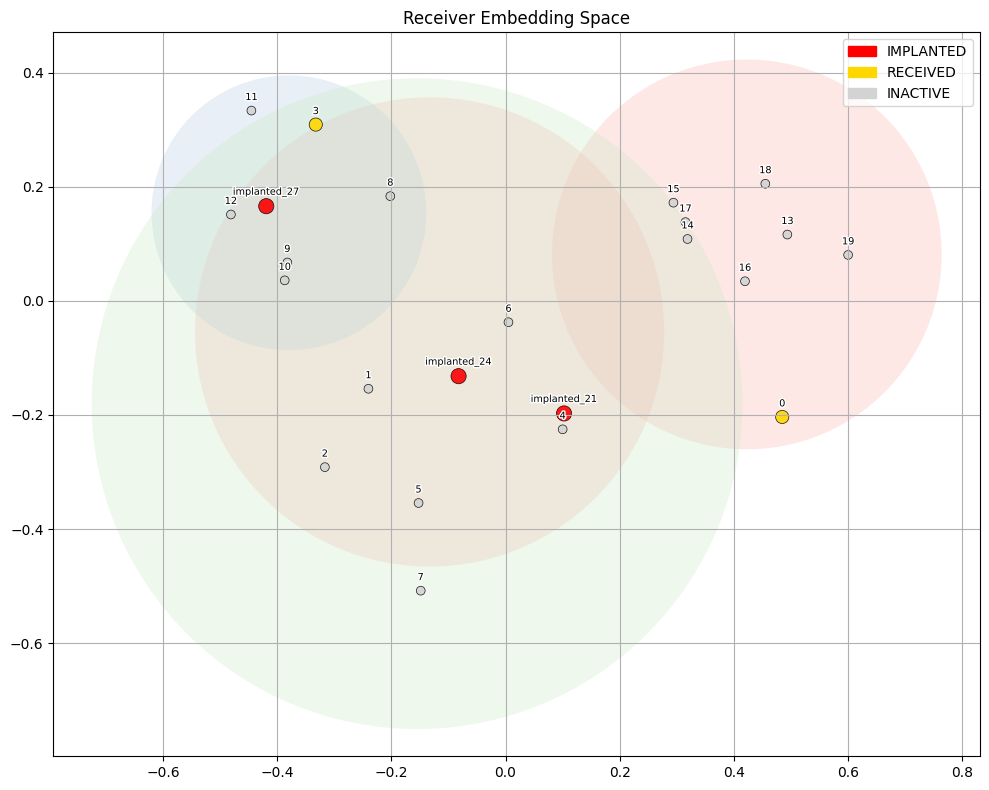

In [2377]:
# Rysowanie PCA embeddingów węzłów w grafie odbiorcy
plot_embedding_space(
    receiver_brain_after,
    title="Receiver Embedding Space",
    save_path=os.path.join(save_dir, "receiver_embedding_space.png")
)

In [ ]:
full_graph_analysis(
    sender_brain=sender_brain,
    info_graph=info,
    transmitted_graph=config["transmitting"],
    receiver_brain_after=receiver_brain_after,
    info_scores=info_scores,
    avg_info=avg_info,
    config=config,
    receiver_brain_before=receiver_brain_before,
    decision_log=decision_log,
    mapping=mapping,
    transmission_sequence=transmission_sequence,
    free_energy=free_energy,
    dissociation_report=dissociation_report
    
)

In [2379]:
# from pyvis.network import Network
# from IPython.display import IFrame
# from matplotlib.cm import get_cmap
# import networkx as nx
# import os


# def show_interactive_receiver_brain_cluster_implanted(receiver_brain, config, report_root="report"):
#     """
#     Generates an interactive HTML visualization of the receiver's brain graph with:
#     - Color by cluster,
#     - Size and color by state (IMPLANTED = red),
#     - RECEIVED and INACTIVE distinguished by size.
    
#     Parameters:
#         receiver_brain (networkx.Graph): Graph of the receiver brain.
#         config (dict): Configuration dictionary with simulation parameters.
#         report_root (str): Base directory for saving the output.
    
#     Returns:
#         IPython.display.IFrame: Embedded HTML interactive graph view.
#     """
#     # Ścieżka zapisu
#     save_dir = os.path.join(
#         report_root,
#         f"{config['sender_size']}_{config['receiver_size']}_{config['transmitting']}_{config['transmission_prob']}_{config['chaos_level']}",
#         "interactive"
#     )
#     os.makedirs(save_dir, exist_ok=True)
#     filename = os.path.join(save_dir, "receiver_brain_cluster_implanted.html")

#     # Inicjalizacja sieci PyVis
#     net = Network(
#         height="100vh",
#         width="100%",
#         notebook=True,
#         bgcolor="#ffffff",
#         font_color="black"
#     )

#     # Kolorowanie klastra
#     clusters = nx.get_node_attributes(receiver_brain, "cluster")
#     cmap = get_cmap('Set3')

#     for node in receiver_brain.nodes:
#         label = receiver_brain.nodes[node].get("label", str(node))
#         state = receiver_brain.nodes[node].get("state", "INACTIVE")
#         cluster_id = clusters.get(node, 0)

#         color_rgb = cmap(cluster_id % 12)[:3]
#         cluster_color_hex = '#{:02x}{:02x}{:02x}'.format(
#             int(color_rgb[0] * 255),
#             int(color_rgb[1] * 255),
#             int(color_rgb[2] * 255)
#         )

#         if state == "IMPLANTED":
#             size = 30
#             color = "red"
#         elif state == "RECEIVED":
#             size = 20
#             color = cluster_color_hex
#         else:
#             size = 5
#             color = cluster_color_hex

#         net.add_node(node, label=label, color=color, size=size, shape="dot")

#     # Krawędzie
#     for u, v in receiver_brain.edges:
#         net.add_edge(u, v)

#     # Eksport HTML
#     net.show(filename)
#     print(f"Interactive graph saved: {filename}")
#     return IFrame(filename, width="100%", height="1000px")

In [2380]:
from pyvis.network import Network
from IPython.display import IFrame
from matplotlib.cm import get_cmap
import networkx as nx
import os


def show_interactive_receiver_brain_cluster_implanted(receiver_brain, config, report_root="report"):
    """
    Generates an interactive HTML visualization of the receiver's brain graph with:
    - Node color by cluster,
    - Node size and color by state (IMPLANTED = red),
    - Edge color by type: structural (black), semantic (red), logical (blue).

    Returns:
        IPython.display.IFrame: Embedded interactive graph view.
    """
    # Ścieżka zapisu
    save_dir = os.path.join(
        report_root,
        f"{config['sender_size']}_{config['receiver_size']}_{config['transmitting']}_{config['transmission_prob']}_{config['chaos_level']}",
        "interactive"
    )
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, "receiver_brain_cluster_implanted.html")

    # Inicjalizacja sieci PyVis
    net = Network(
        height="100vh",
        width="100%",
        notebook=True,
        bgcolor="#ffffff",
        font_color="black"
    )

    # Kolorowanie klastra
    clusters = nx.get_node_attributes(receiver_brain, "cluster")
    cmap = get_cmap('Set3')

    for node in receiver_brain.nodes:
        label = receiver_brain.nodes[node].get("label", str(node))
        state = receiver_brain.nodes[node].get("state", "INACTIVE")
        cluster_id = clusters.get(node, 0)

        color_rgb = cmap(cluster_id % 12)[:3]
        cluster_color_hex = '#{:02x}{:02x}{:02x}'.format(
            int(color_rgb[0] * 255),
            int(color_rgb[1] * 255),
            int(color_rgb[2] * 255)
        )

        if state == "IMPLANTED":
            size = 30
            color = "red"
        elif state == "RECEIVED":
            size = 20
            color = cluster_color_hex
        else:
            size = 5
            color = cluster_color_hex

        net.add_node(node, label=label, color=color, size=size, shape="dot")

    # Krawędzie z kolorem wg typu
    for u, v, d in receiver_brain.edges(data=True):
        edge_type = d.get("type", "structural")
        if edge_type == "semantic":
            edge_color = "red"
        elif edge_type == "logical":
            edge_color = "blue"
        else:
            edge_color = "black"

        net.add_edge(u, v, color=edge_color)

    # Eksport HTML
    net.show(filename)
    print(f"Interactive graph saved: {filename}")
    return IFrame(filename, width="100%", height="1000px")

In [2381]:
import os
import nbformat
from nbconvert import PythonExporter

# Twoja istniejąca funkcja
def get_report_subdir(report_root="report"):
    subdir = os.path.join(
        report_root,
        f"{config['sender_size']}_{config['receiver_size']}_{config['transmitting']}_{config['transmission_prob']}_{config['chaos_level']}"
    )
    os.makedirs(subdir, exist_ok=True)
    return subdir

def get_report_path(report_root="report"):
    return get_report_subdir(report_root)

def export_full_code(notebook_filename=notebook_filename, report_root="report"):
    """
    Eksportuje cały kod z notebooka .ipynb do pliku .py (bez filtrowania).
    """
    try:
        with open(notebook_filename, "r", encoding="utf-8") as f:
            nb = nbformat.read(f, as_version=4)

        if nb.cells and 'export_full_code' in nb.cells[-1].source:
            nb.cells = nb.cells[:-1]

        exporter = PythonExporter()
        full_code, _ = exporter.from_notebook_node(nb)

        save_dir = get_report_path(report_root)
        os.makedirs(save_dir, exist_ok=True)

        output_path = os.path.join(
            save_dir, os.path.basename(notebook_filename).replace(".ipynb", ".py"))

        with open(output_path, "w", encoding="utf-8") as f:
            f.write(full_code)

        print(f"Zapisano cały kod do '{output_path}'")

    except Exception as e:
        print(f"Błąd eksportu kodu: {e}")


def export_markdown_cells(notebook_filename=notebook_filename, output_name="notebook_definicje.md", report_root="report"):
    """
    Eksportuje wszystkie komórki Markdown z notebooka do pliku .md.
    """
    try:
        with open(notebook_filename, "r", encoding="utf-8") as f:
            nb = nbformat.read(f, as_version=4)

        markdown_cells = [cell['source']
                          for cell in nb.cells if cell['cell_type'] == 'markdown']

        save_dir = get_report_path(report_root)
        os.makedirs(save_dir, exist_ok=True)

        output_path = os.path.join(save_dir, output_name)

        with open(output_path, "w", encoding="utf-8") as f:
            f.write("\n\n".join(markdown_cells))

        print(f"Komórki Markdown zapisane jako '{output_path}'")

    except Exception as e:
        print(f"Błąd eksportu do .md: {e}")


# Wykonanie tylko przy uruchomieniu w Jupyterze lub jako __main__
if __name__ == "__main__" or 'get_ipython' in globals():
    export_full_code()
    export_markdown_cells()


Zapisano cały kod do 'report/30_20_5_1_1/brain.py'
Komórki Markdown zapisane jako 'report/30_20_5_1_1/notebook_definicje.md'


In [2382]:
def show_interactive_graph(graph, filename="interactive_graph.html", report_root="report"):
    """
    Shows any NetworkX graph interactively using PyVis.
    Displays edge weights as labels and optionally varies edge width.

    Supports optional node attrs: 'label', 'state', 'cluster'
    and edge attrs: 'type' (semantic, structural, logical), 'weight'.

    Returns:
        IFrame with interactive graph view.
    """
    from pyvis.network import Network
    from IPython.display import IFrame
    from matplotlib.cm import get_cmap
    import os

    save_dir = os.path.join(report_root, "interactive")
    os.makedirs(save_dir, exist_ok=True)
    filepath = os.path.join(save_dir, filename)

    net = Network(height="100vh", width="100%", notebook=True)

    clusters = nx.get_node_attributes(graph, "cluster")
    cmap = get_cmap('Set3')

    for node in graph.nodes:
        label = graph.nodes[node].get("label", str(node))
        state = graph.nodes[node].get("state", None)
        cluster_id = clusters.get(node, 0)

        color_rgb = cmap(cluster_id % 12)[:3]
        cluster_color_hex = '#{:02x}{:02x}{:02x}'.format(
            int(color_rgb[0] * 255),
            int(color_rgb[1] * 255),
            int(color_rgb[2] * 255)
        )

        if state == "IMPLANTED":
            size = 30
            color = "red"
        elif state == "RECEIVED":
            size = 20
            color = "gold"
        else:
            size = 10
            color = cluster_color_hex

        net.add_node(node, label=label, color=color, size=size, shape="dot")

    for u, v, d in graph.edges(data=True):
        edge_type = d.get("type", None)
        weight = d.get("weight", 1.0)

        if edge_type == "semantic":
            edge_color = "red"
        elif edge_type == "logical":
            edge_color = "blue"
        elif edge_type == "structural":
            edge_color = "black"
        else:
            edge_color = "gray"

        # Skala grubości
        width = max(1, min(10, weight * 10)) if isinstance(weight, (float, int)) else 1

        net.add_edge(
            u, v,
            color=edge_color,
            label=f"{weight:.2f}" if isinstance(weight, (float, int)) else None,
            width=width
        )

    net.show(filepath)
    print(f"Interactive graph with weights saved: {filepath}")
    return IFrame(filepath, width="100%", height="1000px")


In [2383]:
show_interactive_graph(sender_brain)

report/interactive/interactive_graph.html
Interactive graph with weights saved: report/interactive/interactive_graph.html


/var/folders/1r/p1_3kg652bbgwr9qm_hgg_pc0000gn/T/ipykernel_32056/3751574794.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Set3')


In [2384]:
show_interactive_receiver_brain_cluster_implanted(receiver_brain_after, config)

report/30_20_5_1_1/interactive/receiver_brain_cluster_implanted.html
Interactive graph saved: report/30_20_5_1_1/interactive/receiver_brain_cluster_implanted.html


/var/folders/1r/p1_3kg652bbgwr9qm_hgg_pc0000gn/T/ipykernel_32056/2275223465.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Set3')
